# 🌎 Welcome to the CSE151B Spring 2025 Climate Emulation Competition!

Thank you for participating in this exciting challenge focused on building machine learning models to emulate complex climate systems.  
This notebook is provided as a **starter template** to help you:

- Understand how to load and preprocess the dataset  
- Construct a baseline model  
- Train and evaluate predictions using a PyTorch Lightning pipeline  
- Format your predictions for submission to the leaderboard  

You're encouraged to:
- Build on this structure or replace it entirely
- Try more advanced models and training strategies
- Incorporate your own ideas to push the boundaries of what's possible

If you're interested in developing within a repository structure and/or use helpful tools like configuration management (based on Hydra) and logging (with Weights & Biases), we recommend checking out the following Github repo. Such a structure can be useful when running multiple experiments and trying various research ideas.

👉 [https://github.com/salvaRC/cse151b-spring2025-competition](https://github.com/salvaRC/cse151b-spring2025-competition)

Good luck, have fun, and we hope you learn a lot through this process!


### 📦 Install Required Libraries
We install the necessary Python packages for data loading, deep learning, and visualization.


In [1]:
!pip install xarray zarr dask lightning matplotlib wandb cftime einops --quiet

import os
from datetime import datetime
import numpy as np
import xarray as xr
import dask.array as da
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl


### ⚙️ Configuration Setup  
Define all model, data, and training hyperparameters in one place for easy control and reproducibility.

### 📊 Data Configuration

We define the dataset settings used for training and evaluation. This includes:

- **`path`**: Path to the `.zarr` dataset containing monthly climate variables from CMIP6 simulations.
- **`input_vars`**: Climate forcing variables (e.g., CO₂, CH₄) used as model inputs.
- **`output_vars`**: Target variables to predict — surface air temperature (`tas`) and precipitation (`pr`).
- **`target_member_id`**: Ensemble member to use from the simulations (each SSP has 3) for target variables.
- **`train_ssps`**: SSP scenarios used for training (low to high emissions).
- **`test_ssp`**: Scenario held out for evaluation (Must be set to SSP245).
- **`test_months`**: Number of months to include in the test split (Must be set to 120).
- **`batch_size`** and **`num_workers`**: Data loading parameters for PyTorch training.

These settings reflect how the challenge is structured: models must learn from some emission scenarios and generalize to unseen ones.

> ⚠️ **Important:** Do **not modify** the following test settings:
>
> - `test_ssp` must remain **`ssp245`**, which is the held-out evaluation scenario.
> - `test_months` must be **`120`**, corresponding to the last 10 years (monthly resolution) of the scenario.



In [19]:
#NOTE Change the data directory according to where you have your zarr files stored
config = {
    "data": {
        # "path": "/kaggle/input/cse151b-spring2025-competition/processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr",
        "path": "/Users/walterwong/Desktop/CSE 151B/Project/processed_data_cse151b_v2_corrupted_ssp245.zarr",
        "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
        "output_vars": ["tas", "pr"],
        "target_member_id": 0,
        "train_ssps": ["ssp126", "ssp370", "ssp585"],
        "test_ssp": "ssp245",
        "test_months": 360,
        "batch_size": 64,
        "num_workers": 4,
    },
    "model": {
        "type": "simple_cnn",
        "kernel_size": 3,
        "init_dim": 64,
        "depth": 4,
        "dropout_rate": 0.1,
    },
    "training": {
        "lr": 1e-3,
    },
    "trainer": {
        "max_epochs": 10,
        "accelerator": "auto",
        "devices": "auto",
        "precision": 32,
        "deterministic": True,
        "num_sanity_val_steps": 0,
    },
    "seed": 42,
}
pl.seed_everything(config["seed"])  # Set seed for reproducibility

Seed set to 42


42

### 🔧 Spatial Weighting Utility Function

This cell sets up utility functions for reproducibility and spatial weighting:

- **`get_lat_weights(latitude_values)`**: Computes cosine-based area weights for each latitude, accounting for the Earth's curvature. This is critical for evaluating global climate metrics fairly — grid cells near the equator represent larger surface areas than those near the poles.


In [20]:
def get_lat_weights(latitude_values):
    lat_rad = np.deg2rad(latitude_values)
    weights = np.cos(lat_rad)
    return weights / np.mean(weights)

### 🧠 SimpleCNN: A Residual Convolutional Baseline

This is a lightweight baseline model designed to capture spatial patterns in global climate data using convolutional layers.

- The architecture starts with a **convolution + batch norm + ReLU** block to process the input channels.
- It then applies a series of **residual blocks** to extract increasingly abstract spatial features. These help preserve gradient flow during training.
- Finally, a few convolutional layers reduce the feature maps down to the desired number of output channels (`tas` and `pr`).

This model only serves as a **simple baseline for climate emulation**. 

We encourage you to build and experiment with your own models and ideas.


In [21]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super().__init__()
        # Increase kernel size for capturing larger spatial patterns in climate data
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=5, stride=stride, padding=2)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # Use LeakyReLU for better gradient flow with climate data
        self.act = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.act(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.skip(identity)
        return self.act(out)

class SimpleCNN(nn.Module):
    def __init__(self, n_input_channels, n_output_channels, kernel_size=5, init_dim=128, depth=6, dropout_rate=0.3):
        super().__init__()
        # Increased initial dimensions and depth for climate modeling capacity
        self.initial = nn.Sequential(
            nn.Conv2d(n_input_channels, init_dim, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm2d(init_dim),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.res_blocks = nn.ModuleList()
        current_dim = init_dim
        for i in range(depth):
            out_dim = current_dim * 2 if i < depth - 1 else current_dim
            self.res_blocks.append(ResidualBlock(current_dim, out_dim))
            if i < depth - 1:
                current_dim *= 2
                
        # Added spatial attention for focusing on important climate patterns
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(current_dim, 1, kernel_size=1),
            nn.Sigmoid()
        )
        
        self.dropout = nn.Dropout2d(dropout_rate)
        
        # Modified final layers for better climate variable prediction
        self.final = nn.Sequential(
            nn.Conv2d(current_dim, current_dim // 2, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm2d(current_dim // 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(current_dim // 2, current_dim // 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(current_dim // 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(current_dim // 4, n_output_channels, kernel_size=1),
        )

    def forward(self, x):
        x = self.initial(x)
        for res_block in self.res_blocks:
            x = res_block(x)
            
        # Apply spatial attention
        attention = self.spatial_attention(x)
        x = x * attention
        
        return self.final(self.dropout(x))


In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride), nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.skip(identity)
        return self.relu(out)

class SimpleCNN(nn.Module):
    def __init__(self, n_input_channels, n_output_channels, kernel_size=3, init_dim=64, depth=4, dropout_rate=0.2):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(n_input_channels, init_dim, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm2d(init_dim),
            nn.ReLU(inplace=True),
        )
        self.res_blocks = nn.ModuleList()
        current_dim = init_dim
        for i in range(depth):
            out_dim = current_dim * 2 if i < depth - 1 else current_dim
            self.res_blocks.append(ResidualBlock(current_dim, out_dim))
            if i < depth - 1:
                current_dim *= 2
        self.dropout = nn.Dropout2d(dropout_rate)
        self.final = nn.Sequential(
            nn.Conv2d(current_dim, current_dim // 2, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm2d(current_dim // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(current_dim // 2, n_output_channels, kernel_size=1),
        )

    def forward(self, x):
        x = self.initial(x)
        for res_block in self.res_blocks:
            x = res_block(x)
        return self.final(self.dropout(x))


### 📐 Normalizer: Z-Score Scaling for Climate Inputs & Outputs

This class handles **Z-score normalization**, a crucial preprocessing step for stable and efficient neural network training:

- **`set_input_statistics(mean, std)` / `set_output_statistics(...)`**: Store the mean and standard deviation computed from the training data for later use.
- **`normalize(data, data_type)`**: Standardizes the data using `(x - mean) / std`. This is applied separately to inputs and outputs.
- **`inverse_transform_output(data)`**: Converts model predictions back to the original physical units (e.g., Kelvin for temperature, mm/day for precipitation).

Normalizing the data ensures the model sees inputs with similar dynamic ranges and avoids biases caused by different variable scales.


In [23]:
class Normalizer:
    def __init__(self):
        self.mean_in, self.std_in = None, None
        self.mean_out, self.std_out = None, None

    def set_input_statistics(self, mean, std):
        self.mean_in = mean
        self.std_in = std

    def set_output_statistics(self, mean, std):
        self.mean_out = mean
        self.std_out = std

    def normalize(self, data, data_type):
        if data_type == "input":
            return (data - self.mean_in) / self.std_in
        elif data_type == "output":
            return (data - self.mean_out) / self.std_out

    def inverse_transform_output(self, data):
        return data * self.std_out + self.mean_out


### 🌍 Data Module: Loading, Normalization, and Splitting

This section handles the entire data pipeline, from loading the `.zarr` dataset to preparing PyTorch-ready DataLoaders.

#### `ClimateDataset`
- A simple PyTorch `Dataset` wrapper that preloads the entire (normalized) dataset into memory using Dask.
- Converts the data to PyTorch tensors and handles any `NaN` checks up front.

#### `ClimateDataModule`
A PyTorch Lightning `DataModule` that handles:
- ✅ **Loading data** from different SSP scenarios and ensemble members
- ✅ **Broadcasting non-spatial inputs** (like CO₂) to match spatial grid size
- ✅ **Normalization** using mean/std computed from training data only
- ✅ **Splitting** into training, validation, and test sets:
  - Training: All months from selected SSPs (except last 10 years of SSP370)
  - Validation: Last 10 years (120 months) of SSP370
  - Test: Last 10 years of SSP245 (unseen scenario)
- ✅ **Batching** and parallelized data loading via PyTorch `DataLoader`s
- ✅ **Latitude-based area weighting** for fair climate metric evaluation
- Shape of the inputs are Batch_Size X 5 (num_input_variables) X 48 X 72
- Shape of ouputputs are Batch_Size X 2 (num_output_variables) X 48 X 72

> ℹ️ **Note:** You likely won’t need to modify this class but feel free to make modifications if you want to inlcude different ensemble mebers to feed more data to your models


In [31]:
class ClimateDataset(Dataset):
    def __init__(self, inputs_dask, outputs_dask, output_is_normalized=True):
        self.size = inputs_dask.shape[0]
        print(f"Creating dataset with {self.size} samples...")

        inputs_np = inputs_dask.compute()
        outputs_np = outputs_dask.compute()

        self.inputs = torch.from_numpy(inputs_np).float()
        self.outputs = torch.from_numpy(outputs_np).float()

        if torch.isnan(self.inputs).any() or torch.isnan(self.outputs).any():
            raise ValueError("NaNs found in dataset")

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]


class ClimateDataModule(pl.LightningDataModule):
    def __init__(
        self,
        path,
        input_vars,
        output_vars,
        train_ssps,
        test_ssp,
        target_member_id,
        val_split=0.1,
        test_months=120,
        batch_size=32,
        num_workers=0,
        seed=42,
    ):
        super().__init__()
        self.path = path
        self.input_vars = input_vars
        self.output_vars = output_vars
        self.train_ssps = train_ssps
        self.test_ssp = test_ssp
        self.target_member_id = target_member_id
        self.val_split = val_split
        self.test_months = test_months
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.seed = seed
        self.normalizer = Normalizer()

    def prepare_data(self):
        assert os.path.exists(self.path), f"Data path not found: {self.path}"

    def setup(self, stage=None):
        ds = xr.open_zarr(self.path, consolidated=False, chunks={"time": 24})
        spatial_template = ds["rsdt"].isel(time=0, ssp=0, drop=True)

        def load_ssp(ssp):
            input_dask, output_dask = [], []
            for var in self.input_vars:
                da_var = ds[var].sel(ssp=ssp)
                if "latitude" in da_var.dims:
                    da_var = da_var.rename({"latitude": "y", "longitude": "x"})
                if "member_id" in da_var.dims:
                    da_var = da_var.sel(member_id=self.target_member_id)
                if set(da_var.dims) == {"time"}:
                    da_var = da_var.broadcast_like(spatial_template).transpose("time", "y", "x")
                input_dask.append(da_var.data)

            for var in self.output_vars:
                da_out = ds[var].sel(ssp=ssp, member_id=self.target_member_id)
                if "latitude" in da_out.dims:
                    da_out = da_out.rename({"latitude": "y", "longitude": "x"})
                output_dask.append(da_out.data)

            return da.stack(input_dask, axis=1), da.stack(output_dask, axis=1)

        train_input, train_output, val_input, val_output = [], [], None, None

        for ssp in self.train_ssps:
            x, y = load_ssp(ssp)
            if ssp == "ssp370":
                val_input = x[-self.test_months:]
                val_output = y[-self.test_months:]
                train_input.append(x[:-self.test_months])
                train_output.append(y[:-self.test_months])
            else:
                train_input.append(x)
                train_output.append(y)

        train_input = da.concatenate(train_input, axis=0)
        train_output = da.concatenate(train_output, axis=0)

        self.normalizer.set_input_statistics(
            mean=da.nanmean(train_input, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_input, axis=(0, 2, 3), keepdims=True).compute(),
        )
        self.normalizer.set_output_statistics(
            mean=da.nanmean(train_output, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_output, axis=(0, 2, 3), keepdims=True).compute(),
        )

        train_input_norm = self.normalizer.normalize(train_input, "input")
        train_output_norm = self.normalizer.normalize(train_output, "output")
        val_input_norm = self.normalizer.normalize(val_input, "input")
        val_output_norm = self.normalizer.normalize(val_output, "output")

        test_input, test_output = load_ssp(self.test_ssp)
        test_input = test_input[-self.test_months:]
        test_output = test_output[-self.test_months:]
        test_input_norm = self.normalizer.normalize(test_input, "input")

        self.train_dataset = ClimateDataset(train_input_norm, train_output_norm)
        self.val_dataset = ClimateDataset(val_input_norm, val_output_norm)
        self.test_dataset = ClimateDataset(test_input_norm, test_output, output_is_normalized=False)

        self.lat = spatial_template.y.values
        self.lon = spatial_template.x.values
        self.area_weights = xr.DataArray(get_lat_weights(self.lat), dims=["y"], coords={"y": self.lat})

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,
                          num_workers=self.num_workers, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

    def get_lat_weights(self):
        return self.area_weights

    def get_coords(self):
        return self.lat, self.lon

### ⚡ ClimateEmulationModule: Lightning Wrapper for Climate Model Emulation

This is the core model wrapper built with **PyTorch Lightning**, which organizes the training, validation, and testing logic for the climate emulation task. Lightning abstracts away much of the boilerplate code in PyTorch-based deep learning workflows, making it easier to scale models.

#### ✅ Key Features

- **`training_step` / `validation_step` / `test_step`**: Standard Lightning hooks for computing loss and predictions at each stage. The loss used is **Mean Squared Error (MSE)**.

- **Normalization-aware outputs**:
  - During validation and testing, predictions and targets are denormalized before evaluation using stored mean/std statistics.
  - This ensures evaluation is done in real-world units (Kelvin and mm/day).

- **Metric Evaluation** via `_evaluate()`:
  For each variable (`tas`, `pr`), it calculates:
  - **Monthly Area-Weighted RMSE**
  - **Time-Mean RMSE** (RMSE on 10-year average's)
  - **Time-Stddev MAE** (MAE on 10-year standard deviation; a measure of temporal variability)
    
  These metrics reflect the competition's evaluation criteria and are logged and printed.

- **Kaggle Submission Writer**:
  After testing, predictions are saved to a `.csv` file in the required Kaggle format via `_save_submission()`.

- **Saving Predictions for Visualization**:
  - Validation predictions are saved tao `val_preds.npy` and `val_trues.npy`
  - These can be loaded later for visual inspection of the model's performance.

 🔧 **Feel free to modify any part of this module** (loss functions, evaluation, training logic) to better suit your model or training pipeline / Use pure PyTorch etc.

⚠️ The **final submission `.csv` file must strictly follow the format and naming convention used in `_save_submission()`**, as these `ID`s are used to match predictions to the hidden test set during evaluation.



In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import numpy as np
from torch.utils.data import DataLoader

class TimeDistributed(nn.Module):
    """Applies a module over multiple time steps"""
    def __init__(self, module):
        super(TimeDistributed, self).__init__()
        self.module = module

    def forward(self, x):
        # Reshape to (batch_size * time_steps, ...)
        batch_size, time_steps = x.size(0), x.size(1)
        x_reshaped = x.contiguous().view(batch_size * time_steps, *x.size()[2:])
        
        # Apply module
        y = self.module(x_reshaped)
        
        # Reshape back
        return y.contiguous().view(batch_size, time_steps, *y.size()[1:])

class SpatialAttention(nn.Module):
    """Spatial attention mechanism for focusing on important regions"""
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        
    def forward(self, x):
        # Generate attention map
        attention = torch.sigmoid(self.conv(x))
        return x * attention

class TemporalAttention(nn.Module):
    """Temporal attention mechanism for focusing on important time steps"""
    def __init__(self, hidden_dim):
        super(TemporalAttention, self).__init__()
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        # x shape: [batch, time_steps, features]
        # Generate attention weights
        attention_weights = F.softmax(self.fc(x), dim=1)
        # Apply attention
        context = torch.sum(x * attention_weights, dim=1)
        return context

class ResidualBlock(nn.Module):
    """Residual block with larger kernels for climate patterns"""
    def __init__(self, in_channels, out_channels, kernel_size=5, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, 
                              stride=stride, padding=kernel_size//2, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size,
                              stride=1, padding=kernel_size//2, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection if dimensions change
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class TimeSeriesClimateCNN(nn.Module):
    """CNN model for climate time series prediction with optional LSTM"""
    def __init__(self, n_input_channels, n_output_channels, seq_length=12, 
                 kernel_size=5, init_dim=64, depth=4, dropout_rate=0.3, use_lstm=True):
        super(TimeSeriesClimateCNN, self).__init__()
        
        self.n_input_channels = n_input_channels
        self.n_output_channels = n_output_channels
        self.seq_length = seq_length
        self.use_lstm = use_lstm
        
        # Initial convolutional layer
        self.initial_conv = TimeDistributed(
            nn.Conv2d(n_input_channels, init_dim, kernel_size=kernel_size, 
                     stride=1, padding=kernel_size//2)
        )
        
        # Residual blocks with increasing channels
        self.res_blocks = nn.ModuleList()
        channels = [init_dim * (2**i) for i in range(depth)]
        
        for i in range(depth-1):
            block = TimeDistributed(
                ResidualBlock(channels[i], channels[i+1], kernel_size=kernel_size, stride=2)
            )
            self.res_blocks.append(block)
        
        # Spatial attention after CNN layers
        self.spatial_attention = TimeDistributed(SpatialAttention(channels[-1]))
        
        # Global average pooling to reduce spatial dimensions
        self.gap = TimeDistributed(nn.AdaptiveAvgPool2d(1))
        
        # LSTM for temporal modeling
        if use_lstm:
            self.lstm = nn.LSTM(
                input_size=channels[-1],
                hidden_size=channels[-1],
                num_layers=2,
                batch_first=True,
                dropout=dropout_rate,
                bidirectional=True
            )
            lstm_output_dim = channels[-1] * 2  # bidirectional
        else:
            lstm_output_dim = channels[-1]
        
        # Temporal attention
        self.temporal_attention = TemporalAttention(lstm_output_dim)
        
        # Final prediction layers
        self.dropout = nn.Dropout(dropout_rate)
        
        # Upsampling to original resolution
        self.upsampling = nn.Sequential(
            nn.ConvTranspose2d(lstm_output_dim, channels[-2], kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(channels[-2], channels[-3], kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(channels[-3], n_output_channels, kernel_size=4, stride=2, padding=1)
        )
        
    def forward(self, x):
        # x shape: [batch, time_steps, channels, height, width]
        batch_size = x.size(0)
        
        # Apply initial convolution
        x = self.initial_conv(x)
        
        # Apply residual blocks
        for block in self.res_blocks:
            x = block(x)
        
        # Apply spatial attention
        x = self.spatial_attention(x)
        
        # Global average pooling
        x = self.gap(x)
        x = x.view(batch_size, self.seq_length, -1)  # [batch, time_steps, channels]
        
        # Apply LSTM if enabled
        if self.use_lstm:
            x, _ = self.lstm(x)
        
        # Apply temporal attention to focus on important time steps
        x = self.temporal_attention(x)  # [batch, channels]
        
        # Reshape for upsampling
        x = x.view(batch_size, -1, 1, 1)
        
        # Apply dropout
        x = self.dropout(x)
        
        # Upsampling to get final prediction
        x = self.upsampling(x)
        
        return x

class ClimateTransformerCNN(nn.Module):
    """CNN model with transformer for temporal modeling"""
    def __init__(self, n_input_channels, n_output_channels, seq_length=12, 
                 kernel_size=5, init_dim=64, depth=4, n_heads=8, dropout_rate=0.3):
        super(ClimateTransformerCNN, self).__init__()
        
        self.n_input_channels = n_input_channels
        self.n_output_channels = n_output_channels
        self.seq_length = seq_length
        
        # Initial convolutional layer
        self.initial_conv = TimeDistributed(
            nn.Conv2d(n_input_channels, init_dim, kernel_size=kernel_size, 
                     stride=1, padding=kernel_size//2)
        )
        
        # Residual blocks with increasing channels
        self.res_blocks = nn.ModuleList()
        channels = [init_dim * (2**i) for i in range(depth)]
        
        for i in range(depth-1):
            block = TimeDistributed(
                ResidualBlock(channels[i], channels[i+1], kernel_size=kernel_size, stride=2)
            )
            self.res_blocks.append(block)
        
        # Spatial attention after CNN layers
        self.spatial_attention = TimeDistributed(SpatialAttention(channels[-1]))
        
        # Global average pooling to reduce spatial dimensions
        self.gap = TimeDistributed(nn.AdaptiveAvgPool2d(1))
        
        # Transformer encoder for temporal modeling
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=channels[-1],
            nhead=n_heads,
            dim_feedforward=channels[-1]*4,
            dropout=dropout_rate,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        # Temporal attention
        self.temporal_attention = TemporalAttention(channels[-1])
        
        # Final prediction layers
        self.dropout = nn.Dropout(dropout_rate)
        
        # Upsampling to original resolution
        self.upsampling = nn.Sequential(
            nn.ConvTranspose2d(channels[-1], channels[-2], kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(channels[-2], channels[-3], kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(channels[-3], n_output_channels, kernel_size=4, stride=2, padding=1)
        )
        
    def forward(self, x):
        # x shape: [batch, time_steps, channels, height, width]
        batch_size = x.size(0)
        
        # Apply initial convolution
        x = self.initial_conv(x)
        
        # Apply residual blocks
        for block in self.res_blocks:
            x = block(x)
        
        # Apply spatial attention
        x = self.spatial_attention(x)
        
        # Global average pooling
        x = self.gap(x)
        x = x.view(batch_size, self.seq_length, -1)  # [batch, time_steps, channels]
        
        # Apply transformer encoder
        x = self.transformer_encoder(x)
        
        # Apply temporal attention to focus on important time steps
        x = self.temporal_attention(x)  # [batch, channels]
        
        # Reshape for upsampling
        x = x.view(batch_size, -1, 1, 1)
        
        # Apply dropout
        x = self.dropout(x)
        
        # Upsampling to get final prediction
        x = self.upsampling(x)
        
        return x


In [30]:
import pandas as pd

class ClimateEmulationModule(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-4):
        super().__init__()
        self.model = model
        self.save_hyperparameters(ignore=['model']) # Save all hyperparameters except the model to self.hparams.<param_name>
        self.criterion = nn.MSELoss()
        self.normalizer = None
        self.val_preds, self.val_targets = [], []
        self.test_preds, self.test_targets = [], []

    def forward(self, x):
        return self.model(x)

    def on_fit_start(self):
        self.normalizer = self.trainer.datamodule.normalizer  # Get the normalizer from the datamodule (see above)

    def training_step(self, batch, batch_idx):
        x, y = batch # Unpack inputs and targets (this is the output of the _getitem_ method in the Dataset above)
        y_hat = self(x)   # Forward pass
        loss = self.criterion(y_hat, y)  # Calculate loss
        self.log("train/loss", loss)  # Log loss for tracking
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val/loss", loss)

        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = self.normalizer.inverse_transform_output(y.detach().cpu().numpy())
        self.val_preds.append(y_hat_np)
        self.val_targets.append(y_np)

        return loss

    def on_validation_epoch_end(self):
        # Concatenate all predictions and ground truths from each val step/batch into one array
        preds = np.concatenate(self.val_preds, axis=0)
        trues = np.concatenate(self.val_targets, axis=0)
        self._evaluate(preds, trues, phase="val")
        np.save("val_preds.npy", preds)
        np.save("val_trues.npy", trues)
        self.val_preds.clear()
        self.val_targets.clear()

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = y.detach().cpu().numpy()
        self.test_preds.append(y_hat_np)
        self.test_targets.append(y_np)

    def on_test_epoch_end(self):
        # Concatenate all predictions and ground truths from each test step/batch into one array
        preds = np.concatenate(self.test_preds, axis=0)
        trues = np.concatenate(self.test_targets, axis=0)
        self._evaluate(preds, trues, phase="test")
        self._save_submission(preds)
        self.test_preds.clear()
        self.test_targets.clear()

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

    def _evaluate(self, preds, trues, phase="val"):
        datamodule = self.trainer.datamodule
        area_weights = datamodule.get_lat_weights()
        lat, lon = datamodule.get_coords()
        time = np.arange(preds.shape[0])
        output_vars = datamodule.output_vars

        for i, var in enumerate(output_vars):
            p = preds[:, i]
            t = trues[:, i]
            p_xr = xr.DataArray(p, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
            t_xr = xr.DataArray(t, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

            # RMSE
            rmse = np.sqrt(((p_xr - t_xr) ** 2).weighted(area_weights).mean(("time", "y", "x")).item())
            # RMSE of time-mean
            mean_rmse = np.sqrt(((p_xr.mean("time") - t_xr.mean("time")) ** 2).weighted(area_weights).mean(("y", "x")).item())
            # MAE of time-stddev
            std_mae = np.abs(p_xr.std("time") - t_xr.std("time")).weighted(area_weights).mean(("y", "x")).item()

            print(f"[{phase.upper()}] {var}: RMSE={rmse:.4f}, Time-Mean RMSE={mean_rmse:.4f}, Time-Stddev MAE={std_mae:.4f}")
            self.log_dict({
                f"{phase}/{var}/rmse": rmse,
                f"{phase}/{var}/time_mean_rmse": mean_rmse,
                f"{phase}/{var}/time_std_mae": std_mae,
            })

    def _save_submission(self, predictions):
        datamodule = self.trainer.datamodule
        lat, lon = datamodule.get_coords()
        output_vars = datamodule.output_vars
        time = np.arange(predictions.shape[0])

        rows = []
        for t_idx, t in enumerate(time):
            for var_idx, var in enumerate(output_vars):
                for y_idx, y in enumerate(lat):
                    for x_idx, x in enumerate(lon):
                        row_id = f"t{t_idx:03d}_{var}_{y:.2f}_{x:.2f}"
                        pred = predictions[t_idx, var_idx, y_idx, x_idx]
                        rows.append({"ID": row_id, "Prediction": pred})

        df = pd.DataFrame(rows)
        os.makedirs("submissions", exist_ok=True)
        filepath = f"submissions/kaggle_submission_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(filepath, index=False)
        print(f"✅ Submission saved to: {filepath}")

### ⚡ Training & Evaluation with PyTorch Lightning

This block sets up and runs the training and testing pipeline using **PyTorch Lightning’s `Trainer`**, which abstracts away much of the boilerplate in deep learning workflows.

- **Modular Setup**:
  - `datamodule`: Handles loading, normalization, and batching of climate data.
  - `model`: A convolutional neural network that maps climate forcings to predicted outputs.
  - `lightning_module`: Wraps the model with training/validation/test logic and metric evaluation.

- **Trainer Flexibility**:
  The `Trainer` accepts a wide range of configuration options from `config["trainer"]`, including:
  - Number of epochs
  - Precision (e.g., 16-bit or 32-bit)
  - Device configuration (CPU, GPU, or TPU)
  - Determinism, logging, callbacks, and more

In [ ]:
# # Load data first to check dimensions
# datamodule = ClimateDataModule(**config["data"])
# datamodule.setup("fit")  # This will load the data and prepare it

# # Get input dimensions from the actual data
# sample_batch = next(iter(datamodule.train_dataloader()))
# input_sample, _ = sample_batch
# print(f"Input shape: {input_sample.shape}")  # Should show [batch_size, seq_length, channels, height, width]

# # Create model with correct dimensions
# model = None
# if config["model"]["type"] == "cnn_transformer":
#     model = ClimateTransformerCNN(
#         n_input_channels=input_sample.shape[2],  # Use actual channel count from data
#         n_output_channels=len(config["data"]["output_vars"]),
#         seq_length=input_sample.shape[1],  # Use actual sequence length from data
#         kernel_size=config["model"].get("kernel_size", 5),
#         init_dim=config["model"].get("init_dim", 64),
#         depth=config["model"].get("depth", 4),
#         n_heads=config["model"].get("n_heads", 8),
#         dropout_rate=config["model"].get("dropout_rate", 0.3)
#     )
# else:
#     model = TimeSeriesClimateCNN(
#         n_input_channels=input_sample.shape[2],  # Use actual channel count from data
#         n_output_channels=len(config["data"]["output_vars"]),
#         seq_length=input_sample.shape[1],  # Use actual sequence length from data
#         kernel_size=config["model"].get("kernel_size", 5),
#         init_dim=config["model"].get("init_dim", 64),
#         depth=config["model"].get("depth", 4),
#         dropout_rate=config["model"].get("dropout_rate", 0.3)
#     )

# lightning_module = ClimateEmulationModule(model, learning_rate=config["training"]["lr"])

# trainer = pl.Trainer(**config["trainer"])
# try:
#     trainer.fit(lightning_module, datamodule=datamodule)   # Training
# except KeyboardInterrupt:
#     print("Training interrupted by user")
# except Exception as e:
#     print(f"Error during training: {e}")
#     import traceback
#     traceback.print_exc()

In [32]:
from models import SequentialClimateCNN

datamodule = ClimateDataModule(**config["data"])
model = SequentialClimateCNN(
    n_input_channels=len(config["data"]["input_vars"]),
    n_output_channels=len(config["data"]["output_vars"]),
    seq_length=config["data"].get("seq_length", 12),
    kernel_size=config["model"].get("kernel_size", 5),
    hidden_dim=config["model"].get("init_dim", 64),
    spatial_depth=config["model"].get("depth", 3),
    dropout_rate=config["model"].get("dropout_rate", 0.3)
)
lightning_module = ClimateEmulationModule(model, learning_rate=config["training"]["lr"])

trainer = pl.Trainer(**config["trainer"])
trainer.fit(lightning_module, datamodule=datamodule)   #

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Creating dataset with 2703 samples...



  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | SequentialClimateCNN | 1.3 M  | train
1 | criterion | MSELoss              | 0      | train
-----------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.036     Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Creating dataset with 360 samples...
Creating dataset with 360 samples...


/Users/walterwong/miniforge3/envs/project_env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
python(88794) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88795) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88796) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88797) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/walterwong/miniforge3/envs/project_env/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/Users/walterwong/miniforge3/envs/project_env/lib/py

Epoch 0:   0%|          | 0/43 [00:00<?, ?it/s] 

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/walterwong/miniforge3/envs/project_env/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/walterwong/miniforge3/envs/project_env/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/walterwong/miniforge3/envs/project_env/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/walterwong/miniforge3/envs/project_env/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
Traceback (most recent call last):
  File "<string>", line 1, in <module>
    exitcode = _main(fd, parent_sentinel)
  File "/Users/walterwong/miniforge3/envs/project_env/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
  File "/Users/walterwong/miniforge

Error during training: DataLoader worker (pid(s) 88794, 88795, 88796, 88797) exited unexpectedly


Traceback (most recent call last):
  File "/Users/walterwong/miniforge3/envs/project_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1133, in _try_get_data
    data = self._data_queue.get(timeout=timeout)
  File "/Users/walterwong/miniforge3/envs/project_env/lib/python3.9/multiprocessing/queues.py", line 114, in get
    raise Empty
_queue.Empty

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/var/folders/75/4b4y2mlx2yv_34rkxb83ydkr0000gn/T/ipykernel_82012/3482048120.py", line 42, in <module>
    trainer.fit(lightning_module, datamodule=datamodule)
  File "/Users/walterwong/miniforge3/envs/project_env/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 561, in fit
    call._call_and_handle_interrupt(
  File "/Users/walterwong/miniforge3/envs/project_env/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py", line 48, in _call_and_handle_interrupt
    return trainer_fn(*arg

In [ ]:
datamodule = ClimateDataModule(**config["data"])
model = SimpleCNN(
    n_input_channels=len(config["data"]["input_vars"]),
    n_output_channels=len(config["data"]["output_vars"]),
    **{k: v for k, v in config["model"].items() if k != "type"}
)
lightning_module = ClimateEmulationModule(model, learning_rate=config["training"]["lr"])

trainer = pl.Trainer(**config["trainer"])
trainer.fit(lightning_module, datamodule=datamodule)   # Training

# Test model

**IMPORTANT:** Please note that the test metrics will be bad because the test targets have been corrupted on the public Kaggle dataset.
The purpose of testing below is to generate the Kaggle submission file based on your model's predictions, which you can submit to the competition.

In [ ]:
trainer.test(lightning_module, datamodule=datamodule) 

### Plotting Utils


In [ ]:
def plot_comparison(true_xr, pred_xr, title, cmap='viridis', diff_cmap='RdBu_r', metric=None):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    vmin = min(true_xr.min().item(), pred_xr.min().item())
    vmax = max(true_xr.max().item(), pred_xr.max().item())

    # Ground truth
    true_xr.plot(ax=axs[0], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[0].set_title(f"{title} (Ground Truth)")

    # Prediction
    pred_xr.plot(ax=axs[1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[1].set_title(f"{title} (Prediction)")

    # Difference
    diff = pred_xr - true_xr
    abs_max = np.max(np.abs(diff))
    diff.plot(ax=axs[2], cmap=diff_cmap, vmin=-abs_max, vmax=abs_max, add_colorbar=True)
    axs[2].set_title(f"{title} (Difference) {f'- {metric:.4f}' if metric else ''}")

    plt.tight_layout()
    plt.show()


### 🖼️ Visualizing Validation Predictions

This cell loads saved validation predictions and compares them to the ground truth using spatial plots. These visualizations help you qualitatively assess your model's performance.

For each output variable (`tas`, `pr`), we visualize:

- **📈 Time-Mean Map**: The 10-year average spatial pattern for both prediction and ground truth. Helps identify long-term biases or spatial shifts.
- **📊 Time-Stddev Map**: Shows the standard deviation across time for each grid cell — useful for assessing how well the model captures **temporal variability** at each location.
- **🕓 Random Timestep Sample**: Visual comparison of prediction vs ground truth for a single month. Useful for spotting fine-grained anomalies or errors in specific months.

> These plots provide intuition beyond metrics and are useful for debugging spatial or temporal model failures.


In [ ]:
# Load validation predictions
# make sure to have run the validation loop at least once
val_preds = np.load("val_preds.npy")
val_trues = np.load("val_trues.npy")

lat, lon = datamodule.get_coords()
output_vars = datamodule.output_vars
time = np.arange(val_preds.shape[0])

for i, var in enumerate(output_vars):
    pred_xr = xr.DataArray(val_preds[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
    true_xr = xr.DataArray(val_trues[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

    # --- Time Mean ---
    plot_comparison(true_xr.mean("time"), pred_xr.mean("time"), f"{var} Val Time-Mean")

    # --- Time Stddev ---
    plot_comparison(true_xr.std("time"), pred_xr.std("time"), f"{var} Val Time-Stddev", cmap="plasma")

    # --- Random timestep ---
    t_idx = np.random.randint(0, len(time))
    plot_comparison(true_xr.isel(time=t_idx), pred_xr.isel(time=t_idx), f"{var} Val Sample Timestep {t_idx}")


## 🧪 Final Notes

This notebook is meant to serve as a **baseline template** — a starting point to help you get up and running quickly with the climate emulation challenge.

You are **not** required to stick to this exact setup. In fact, we **encourage** you to:

- 🔁 Build on top of the provided `DataModule`. 
- 🧠 Use your own model architectures or training pipelines that you’re more comfortable with 
- ⚗️ Experiment with ideas  
- 🥇 Compete creatively to climb the Kaggle leaderboard  
- 🙌 Most importantly: **have fun** and **learn as much as you can** along the way

This challenge simulates a real-world scientific problem, and there’s no single "correct" approach — so be curious, experiment boldly, and make it your own!


In [4]:
import xarray as xr
import pandas as pd

# Load the zarr dataset
ds = xr.open_zarr("processed_data_cse151b_v2_corrupted_ssp245.zarr")

# Convert to pandas dataframes - one for each variable
dfs = {}
for var in ds.data_vars:
    # Reshape the 4D array (time, level, lat, lon) into a 2D dataframe
    # Flatten spatial dimensions into single columns
    df = ds[var].to_dataframe().reset_index()
    
    # Add meaningful column names for spatial coordinates
    # First check if coordinates exist before assigning
    if 'y' in df.columns:
        df['latitude'] = df['y']
    if 'x' in df.columns:  
        df['longitude'] = df['x']
    
    # Store in dictionary
    dfs[var] = df

# Example usage:
# Access individual dataframes like:
# dfs['tas'] for temperature
# dfs['pr'] for precipitation
# etc.

# Print available variables
print("Available variables:")
for var in dfs.keys():
    print(f"- {var}: {dfs[var].shape}")


Available variables:
- BC: (14114304, 5)
- CH4: (4084, 3)
- CO2: (4084, 3)
- SO2: (14114304, 5)
- pr: (42342912, 10)
- rsdt: (14114304, 9)
- tas: (42342912, 10)


In [5]:
dfs.keys()

dict_keys(['BC', 'CH4', 'CO2', 'SO2', 'pr', 'rsdt', 'tas'])

In [6]:
len(dfs['BC'][dfs['BC']['ssp'] == 'ssp126']['time'].unique())

1021

In [7]:
dfs['pr']

,ssp,time,member_id,y,x,lat,lon,pr,latitude,longitude
0,ssp126,2015-01-15 00:00:00,0,-88.586387,1.875,-88.586387,91.875,0.050370,-88.586387,1.875
1,ssp126,2015-01-15 00:00:00,0,-88.586387,6.875,-88.586387,6.875,0.047009,-88.586387,6.875
2,ssp126,2015-01-15 00:00:00,0,-88.586387,11.875,-88.586387,11.875,0.037265,-88.586387,11.875
3,ssp126,2015-01-15 00:00:00,0,-88.586387,16.875,-88.586387,16.875,0.029432,-88.586387,16.875
4,ssp126,2015-01-15 00:00:00,0,-88.586387,21.875,-88.586387,21.875,0.024712,-88.586387,21.875
...,...,...,...,...,...,...,...,...,...,...
42342907,ssp585,2100-01-15 00:00:00,2,88.586387,336.875,88.586387,336.875,1.055148,88.586387,336.875
42342908,ssp585,2100-01-15 00:00:00,2,88.586387,341.875,88.586387,341.875,1.058902,88.586387,341.875
42342909,ssp585,2100-01-15 00:00:00,2,88.586387,346.875,88.586387,346.875,1.067653,88.586387,346.875
42342910,ssp585,2100-01-15 00:00:00,2,88.586387,351.875,88.586387,351.875,1.093096,88.586387,351.875


In [17]:
dfs['BC'][dfs['BC']['ssp'] == 'ssp126'][10000:10020]

,ssp,time,latitude,longitude,BC
10000,ssp126,2015-03-15 00:00:00,70.105263,321.25,0.000000e+00
10001,ssp126,2015-03-15 00:00:00,70.105263,326.25,3.066604e-18
10002,ssp126,2015-03-15 00:00:00,70.105263,331.25,3.344667e-16
10003,ssp126,2015-03-15 00:00:00,70.105263,336.25,3.575927e-15
10004,ssp126,2015-03-15 00:00:00,70.105263,341.25,5.535903e-15
10005,ssp126,2015-03-15 00:00:00,70.105263,346.25,6.831938e-15
10006,ssp126,2015-03-15 00:00:00,70.105263,351.25,2.223533e-15
10007,ssp126,2015-03-15 00:00:00,70.105263,356.25,2.927953e-15
10008,ssp126,2015-03-15 00:00:00,73.894737,1.25,5.750513e-15
10009,ssp126,2015-03-15 00:00:00,73.894737,6.25,1.958630e-14


In [45]:
len(dfs['BC']['longitude'].value_counts().index)

72

In [38]:
dfs['CH4']['ssp'].value_counts()

ssp
ssp126    1021
ssp245    1021
ssp370    1021
ssp585    1021
Name: count, dtype: int64

In [41]:
2943 + 120

3063

In [40]:
1021*3

3063

In [ ]:
dfs['tas']

In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
dfs['tas']

,ssp,time,member_id,y,x,lat,lon,tas,latitude,longitude
0,ssp126,2015-01-15 00:00:00,0,-88.586387,1.875,-88.586387,91.875,246.604187,-88.586387,1.875
1,ssp126,2015-01-15 00:00:00,0,-88.586387,6.875,-88.586387,6.875,246.459167,-88.586387,6.875
2,ssp126,2015-01-15 00:00:00,0,-88.586387,11.875,-88.586387,11.875,246.182907,-88.586387,11.875
3,ssp126,2015-01-15 00:00:00,0,-88.586387,16.875,-88.586387,16.875,246.052322,-88.586387,16.875
4,ssp126,2015-01-15 00:00:00,0,-88.586387,21.875,-88.586387,21.875,245.922592,-88.586387,21.875
...,...,...,...,...,...,...,...,...,...,...
42342907,ssp585,2100-01-15 00:00:00,2,88.586387,336.875,88.586387,336.875,271.739624,88.586387,336.875
42342908,ssp585,2100-01-15 00:00:00,2,88.586387,341.875,88.586387,341.875,271.784546,88.586387,341.875
42342909,ssp585,2100-01-15 00:00:00,2,88.586387,346.875,88.586387,346.875,271.837921,88.586387,346.875
42342910,ssp585,2100-01-15 00:00:00,2,88.586387,351.875,88.586387,351.875,271.896912,88.586387,351.875


In [19]:
zero_kelvin = dfs['tas'][dfs['tas']['tas'] < 10]

In [24]:
zero_kelvin['ssp'].value_counts()

ssp
ssp245    10585728
Name: count, dtype: int64

# Distribution of temperature values (including and not including ssp245)

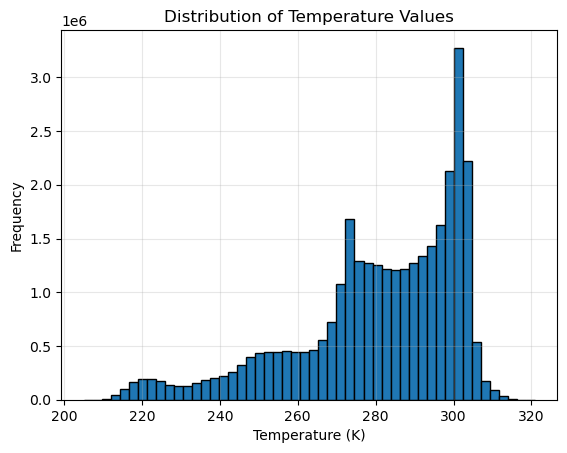

In [29]:
plt.hist(np.array(dfs['tas'][dfs['tas']['ssp'] != 'ssp245']['tas']), bins=50, edgecolor='black', linewidth=1)
plt.title('Distribution of Temperature Values')
plt.xlabel('Temperature (K)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

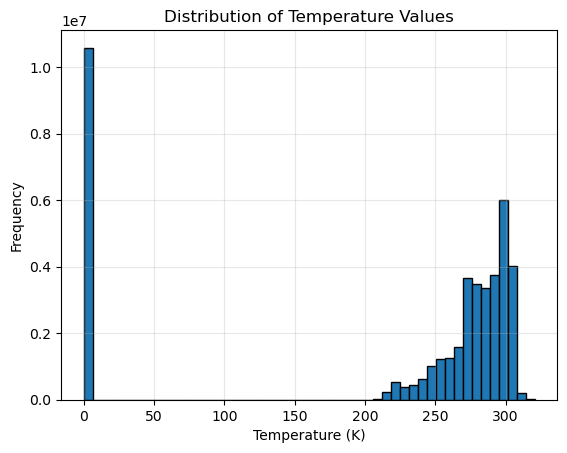

In [28]:
plt.hist(np.array(dfs['tas']['tas']), bins=50, edgecolor='black', linewidth=1)
plt.title('Distribution of Temperature Values')
plt.xlabel('Temperature (K)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

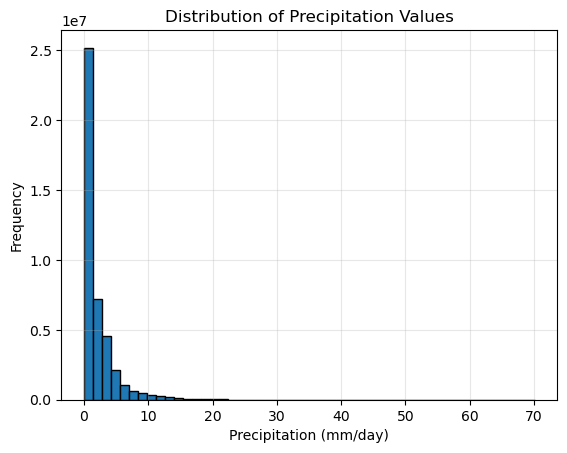

In [32]:
plt.hist(np.array(dfs['pr']['pr']), bins=50, edgecolor='black', linewidth=1)
plt.title('Distribution of Precipitation Values')
plt.xlabel('Precipitation (mm/day)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

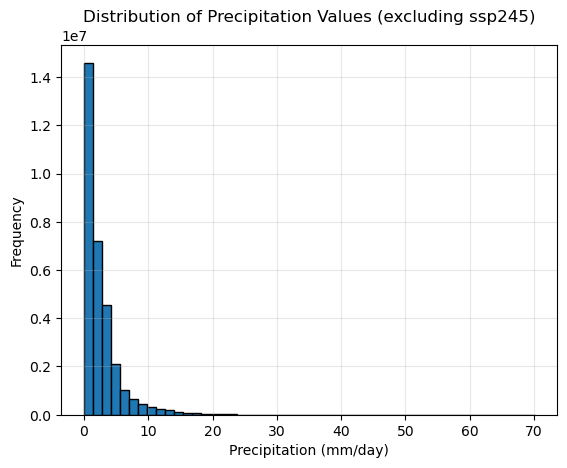

In [33]:
plt.hist(np.array(dfs['pr'][dfs['pr']['ssp'] != 'ssp245']['pr']), bins=50, edgecolor='black', linewidth=1)
plt.title('Distribution of Precipitation Values (excluding ssp245)')
plt.xlabel('Precipitation (mm/day)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# Distribution of Input Variables

Mean CH4:
0.4027893495002597
Std CH4:
0.16515540600671794


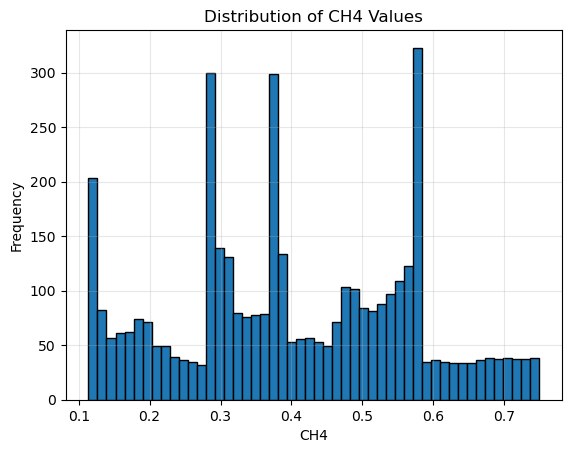

In [46]:
print('Mean CH4:')
print(np.mean(np.array(dfs['CH4']['CH4'])))
print('Std CH4:')
print(np.std(np.array(dfs['CH4']['CH4'])))

plt.hist(np.array(dfs['CH4']['CH4']), bins=50, edgecolor='black', linewidth=1)
plt.title('Distribution of CH4 Values')
plt.xlabel('CH4')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()


Mean CO2:
3562.998212546647
Std CO2:
1683.4495533043969


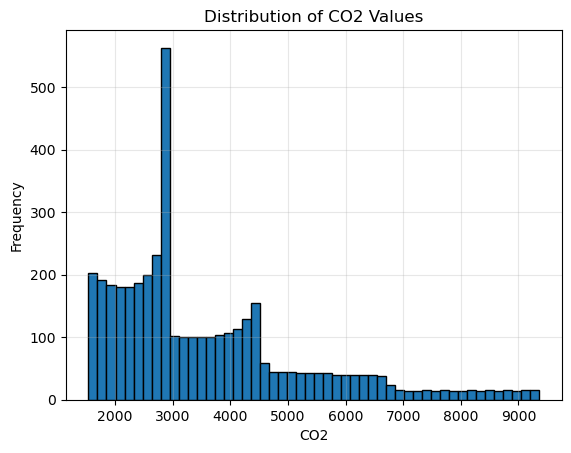

In [47]:
print('Mean CO2:')
print(np.mean(np.array(dfs['CO2']['CO2'])))
print('Std CO2:')
print(np.std(np.array(dfs['CO2']['CO2'])))

plt.hist(np.array(dfs['CO2']['CO2']), bins=50, edgecolor='black', linewidth=1)
plt.title('Distribution of CO2 Values')
plt.xlabel('CO2')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

In [48]:
dfs.keys()

dict_keys(['BC', 'CH4', 'CO2', 'SO2', 'pr', 'rsdt', 'tas'])

Mean BC:
2.3013998163115786e-13
Std BC:
1.2416409098582695e-12


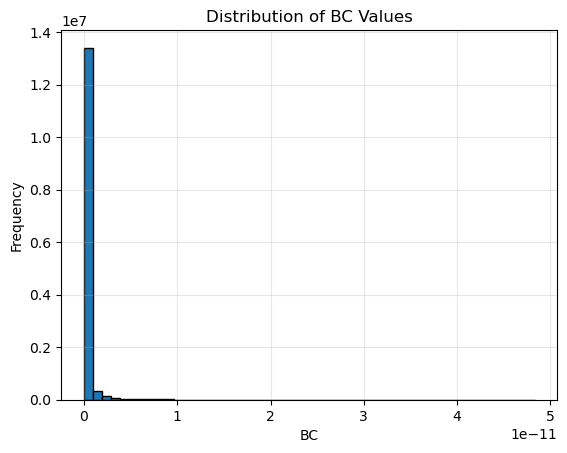

In [49]:
print('Mean BC:')
print(np.mean(np.array(dfs['BC']['BC'])))
print('Std BC:')
print(np.std(np.array(dfs['BC']['BC'])))

plt.hist(np.array(dfs['BC']['BC']), bins=50, edgecolor='black', linewidth=1)
plt.title('Distribution of BC Values')
plt.xlabel('BC')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

Mean SO2:
2.7289931231803786e-12
Std SO2:
1.5275655098050523e-11


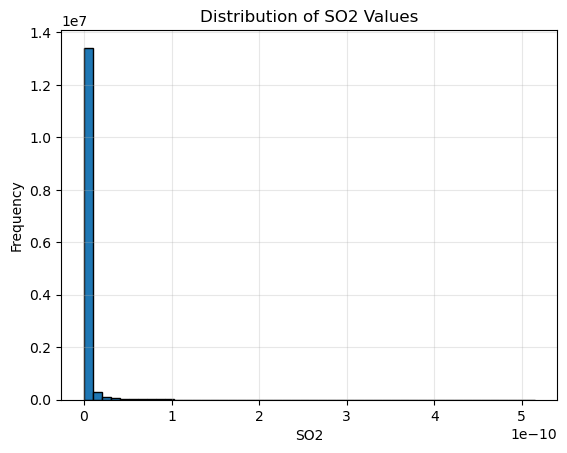

In [50]:
print('Mean SO2:')
print(np.mean(np.array(dfs['SO2']['SO2'])))
print('Std SO2:')
print(np.std(np.array(dfs['SO2']['SO2'])))

plt.hist(np.array(dfs['SO2']['SO2']), bins=50, edgecolor='black', linewidth=1)
plt.title('Distribution of SO2 Values')
plt.xlabel('SO2')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

Mean rsdt:
297.654
Std rsdt:
164.0909


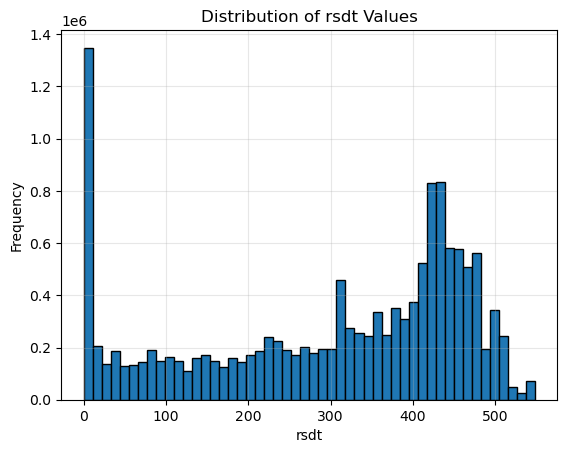

In [51]:
print('Mean rsdt:')
print(np.mean(np.array(dfs['rsdt']['rsdt'])))
print('Std rsdt:')
print(np.std(np.array(dfs['rsdt']['rsdt'])))

plt.hist(np.array(dfs['rsdt']['rsdt']), bins=50, edgecolor='black', linewidth=1)
plt.title('Distribution of rsdt Values')
plt.xlabel('rsdt')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# Distribution of Target Variables as a function of ssp

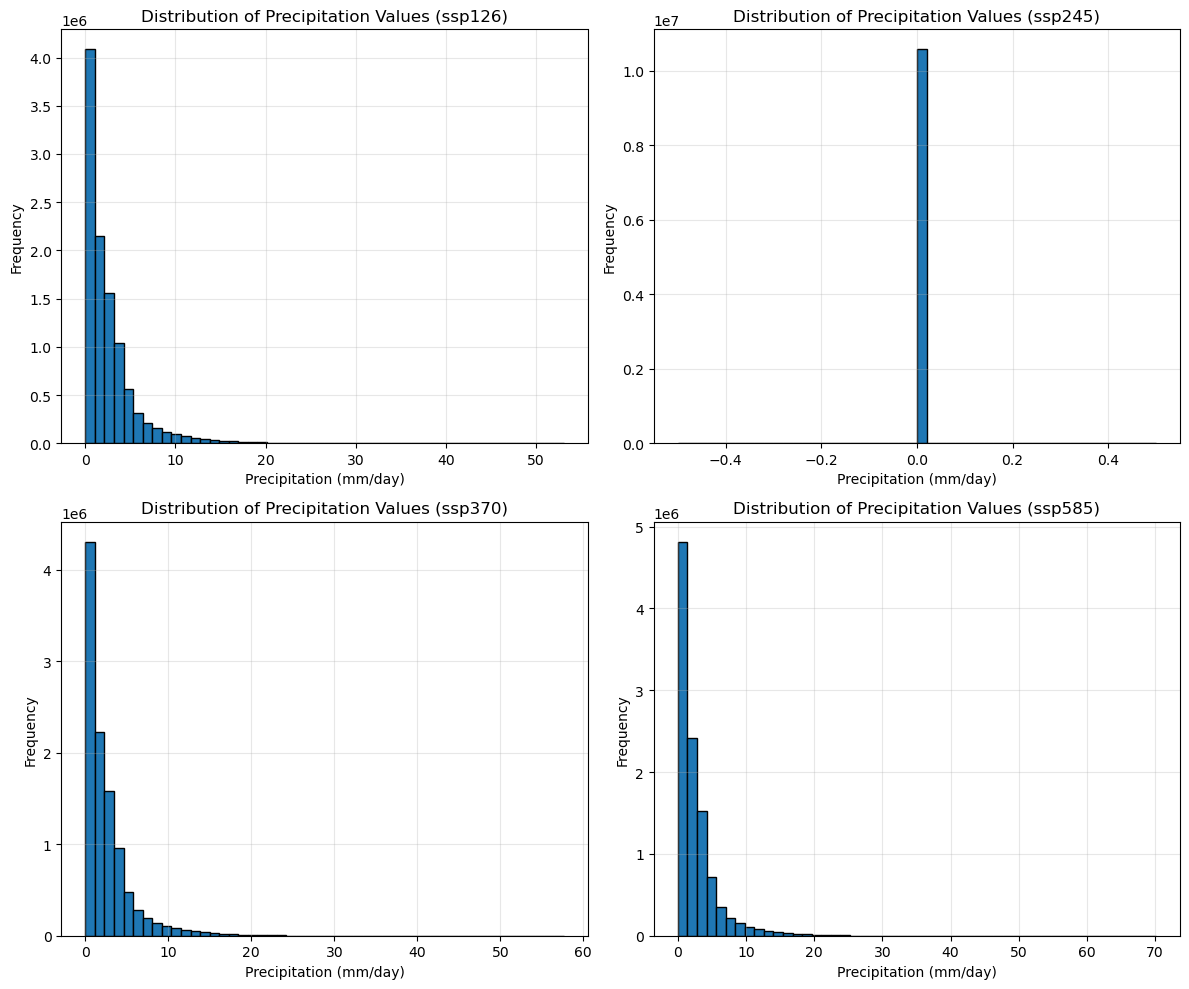

In [52]:
ssps = dfs['pr']['ssp'].unique()

# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot histogram for each SSP in its own subplot
for i, ssp in enumerate(ssps):
    ssp_data = np.array(dfs['pr'][dfs['pr']['ssp'] == ssp]['pr'])
    axes[i].hist(ssp_data, bins=50, edgecolor='black', linewidth=1)
    axes[i].set_title(f'Distribution of Precipitation Values ({ssp})')
    axes[i].set_xlabel('Precipitation (mm/day)')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

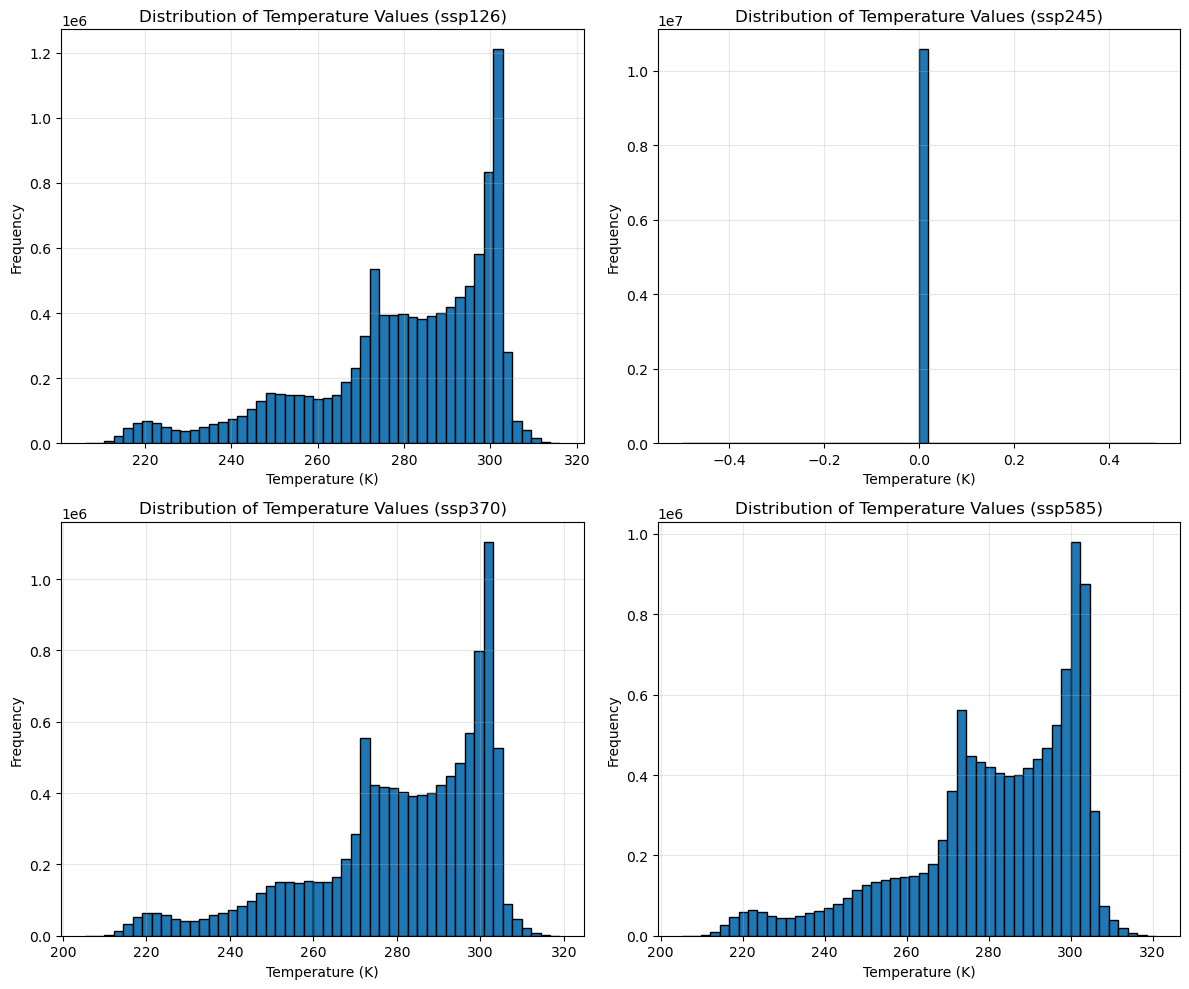

In [57]:
ssps = dfs['tas']['ssp'].unique()

# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot histogram for each SSP in its own subplot
for i, ssp in enumerate(ssps):
    ssp_data = np.array(dfs['tas'][dfs['tas']['ssp'] == ssp]['tas'])
    axes[i].hist(ssp_data, bins=50, edgecolor='black', linewidth=1)
    axes[i].set_title(f'Distribution of Temperature Values ({ssp})')
    axes[i].set_xlabel('Temperature (K)')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Distribution of Target Variables as a function of month

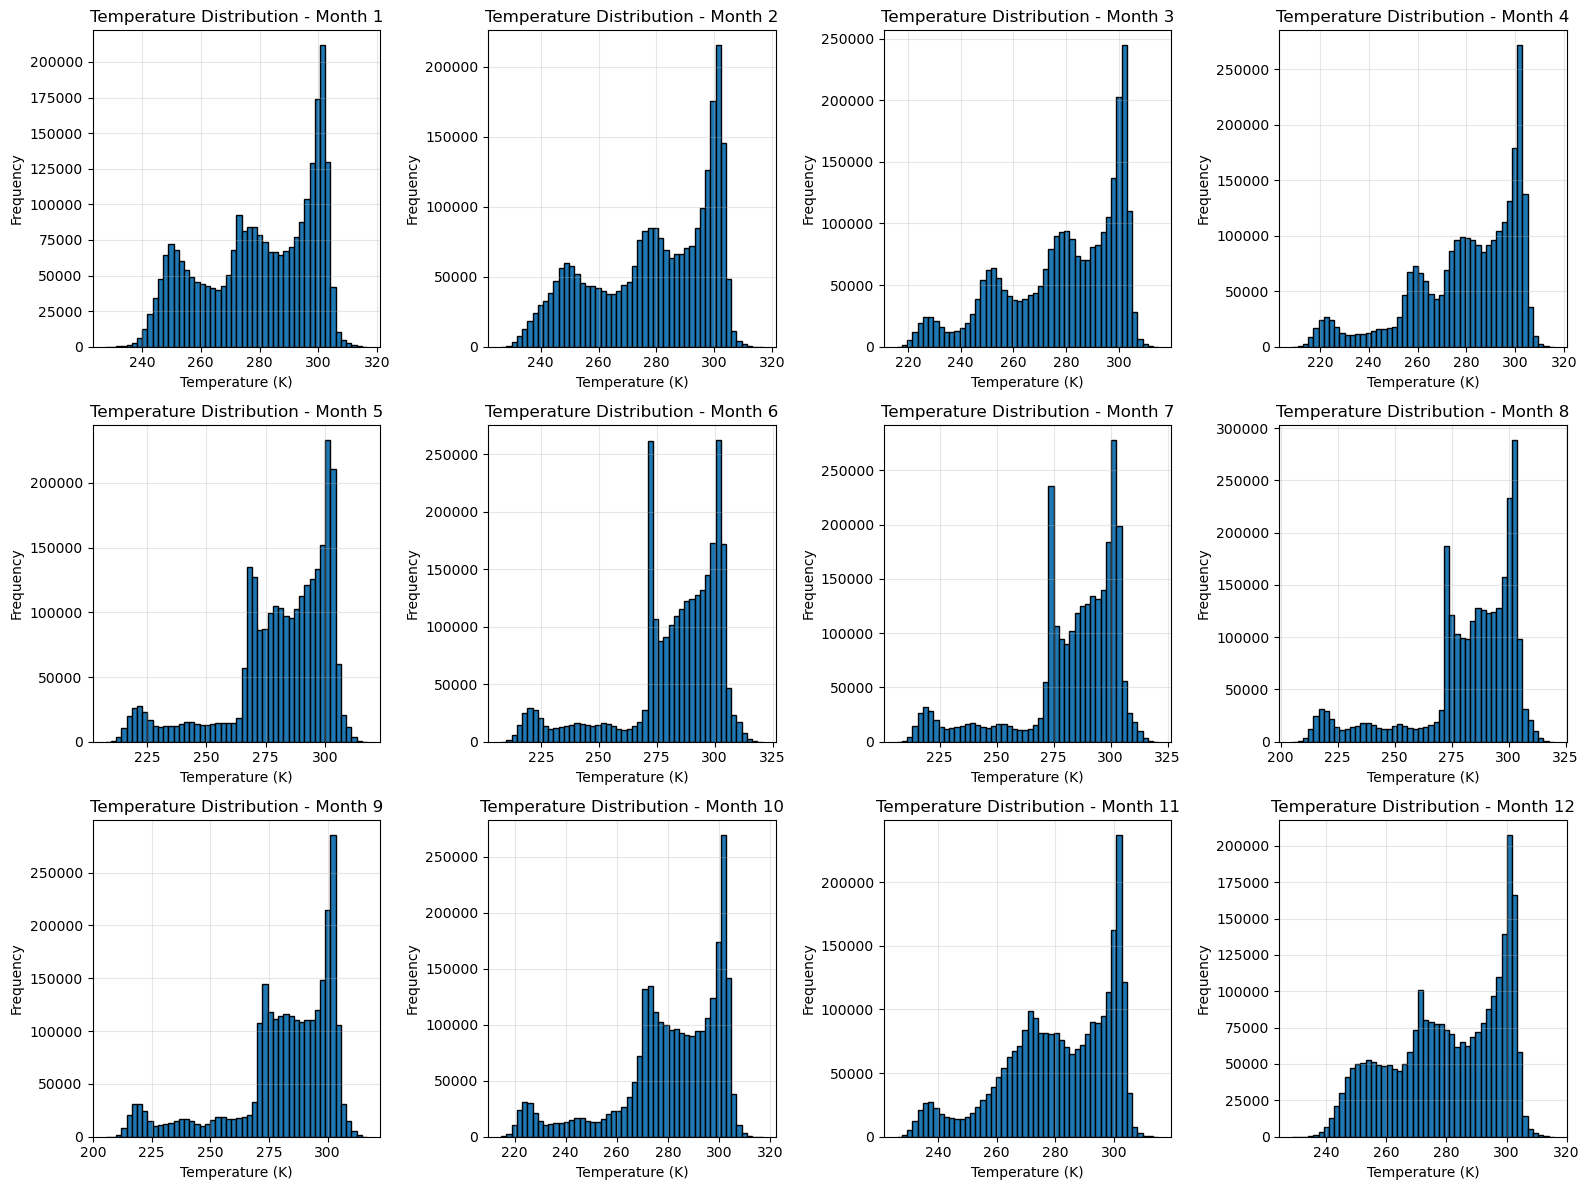

In [54]:
# Extract month directly from the DatetimeNoLeap objects
dfs['tas']['month'] = [time.month for time in dfs['tas']['time']]

# Create a figure with 12 subplots (one for each month)
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

# Plot histogram for each month
for month in range(1, 13):
    ax = axes[month-1]
    month_data = dfs['tas'][(dfs['tas']['ssp'] != 'ssp245') & (dfs['tas']['month'] == month)]
    
    ax.hist(np.array(month_data['tas']), bins=50, edgecolor='black', linewidth=1)
    ax.set_title(f'Temperature Distribution - Month {month}')
    ax.set_xlabel('Temperature (K)')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

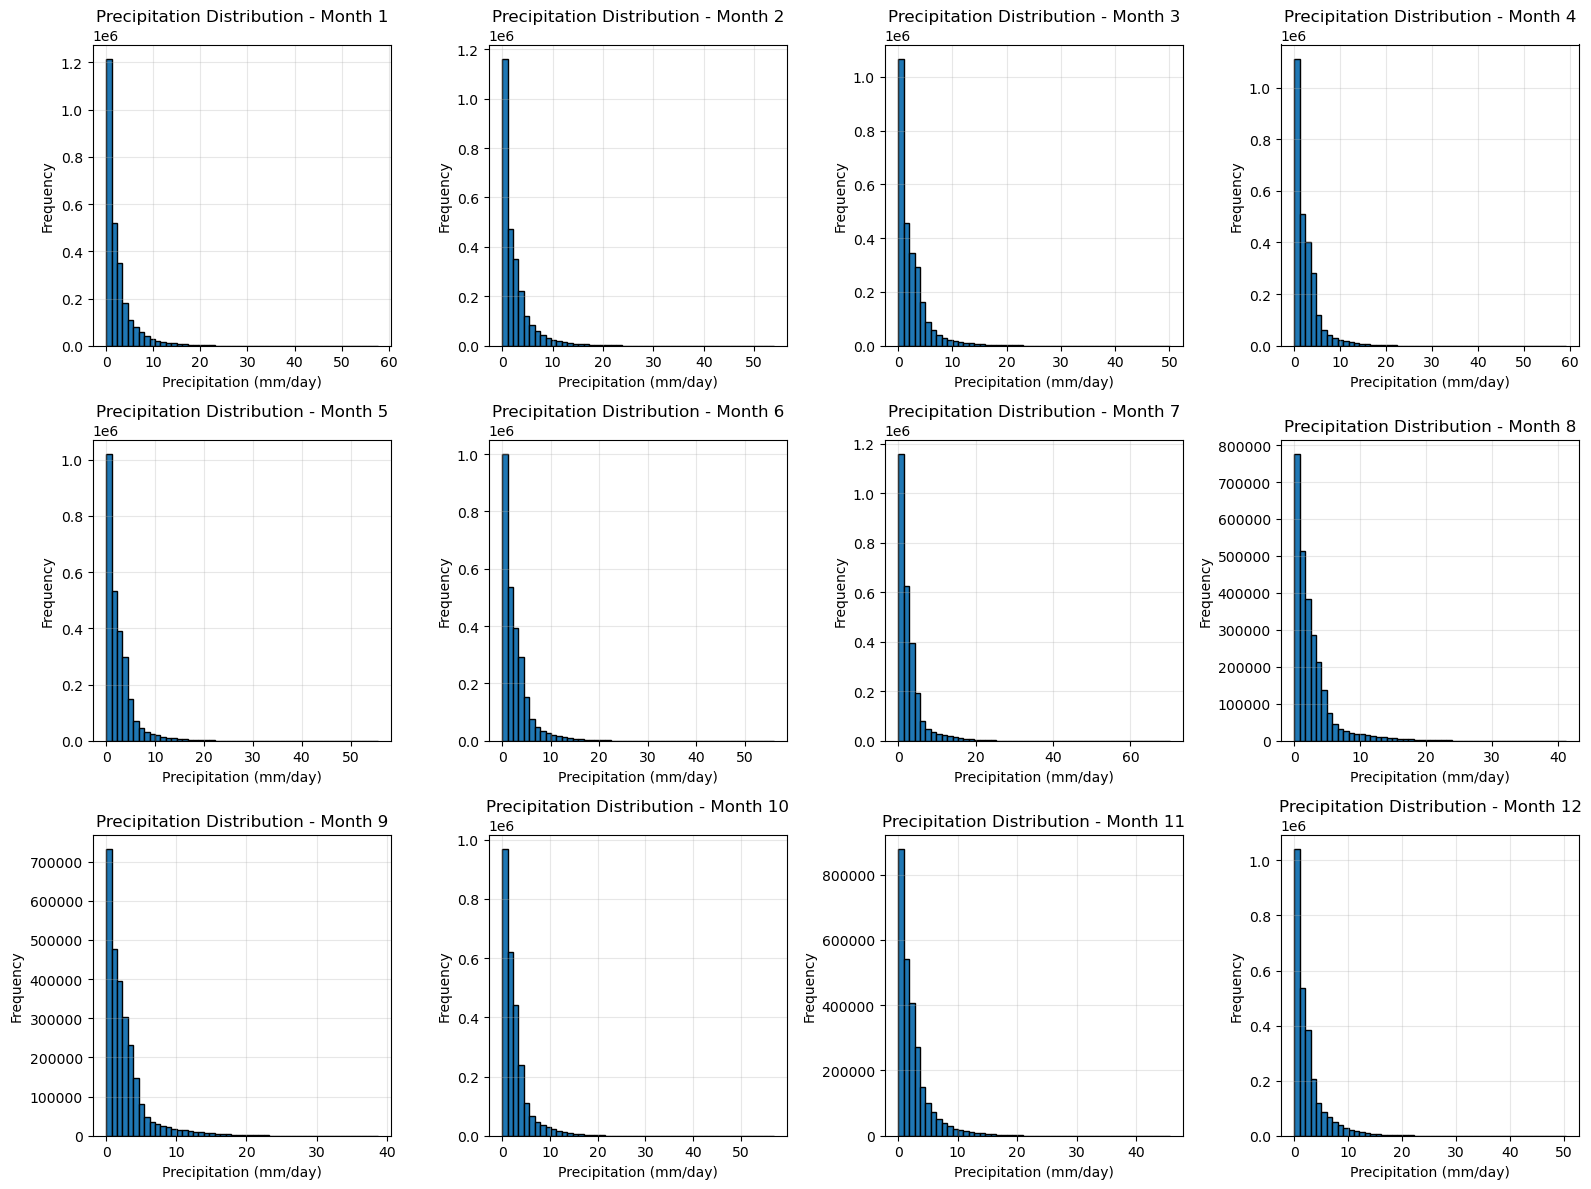

In [55]:
# Extract month directly from the DatetimeNoLeap objects
dfs['pr']['month'] = [time.month for time in dfs['pr']['time']]

# Create a figure with 12 subplots (one for each month)
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

# Plot histogram for each month
for month in range(1, 13):
    ax = axes[month-1]
    month_data = dfs['pr'][(dfs['pr']['ssp'] != 'ssp245') & (dfs['pr']['month'] == month)]
    
    ax.hist(np.array(month_data['pr']), bins=50, edgecolor='black', linewidth=1)
    ax.set_title(f'Precipitation Distribution - Month {month}')
    ax.set_xlabel('Precipitation (mm/day)')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Distribution of Input Variables as a function of ssp

In [58]:
dfs.keys()

dict_keys(['BC', 'CH4', 'CO2', 'SO2', 'pr', 'rsdt', 'tas'])

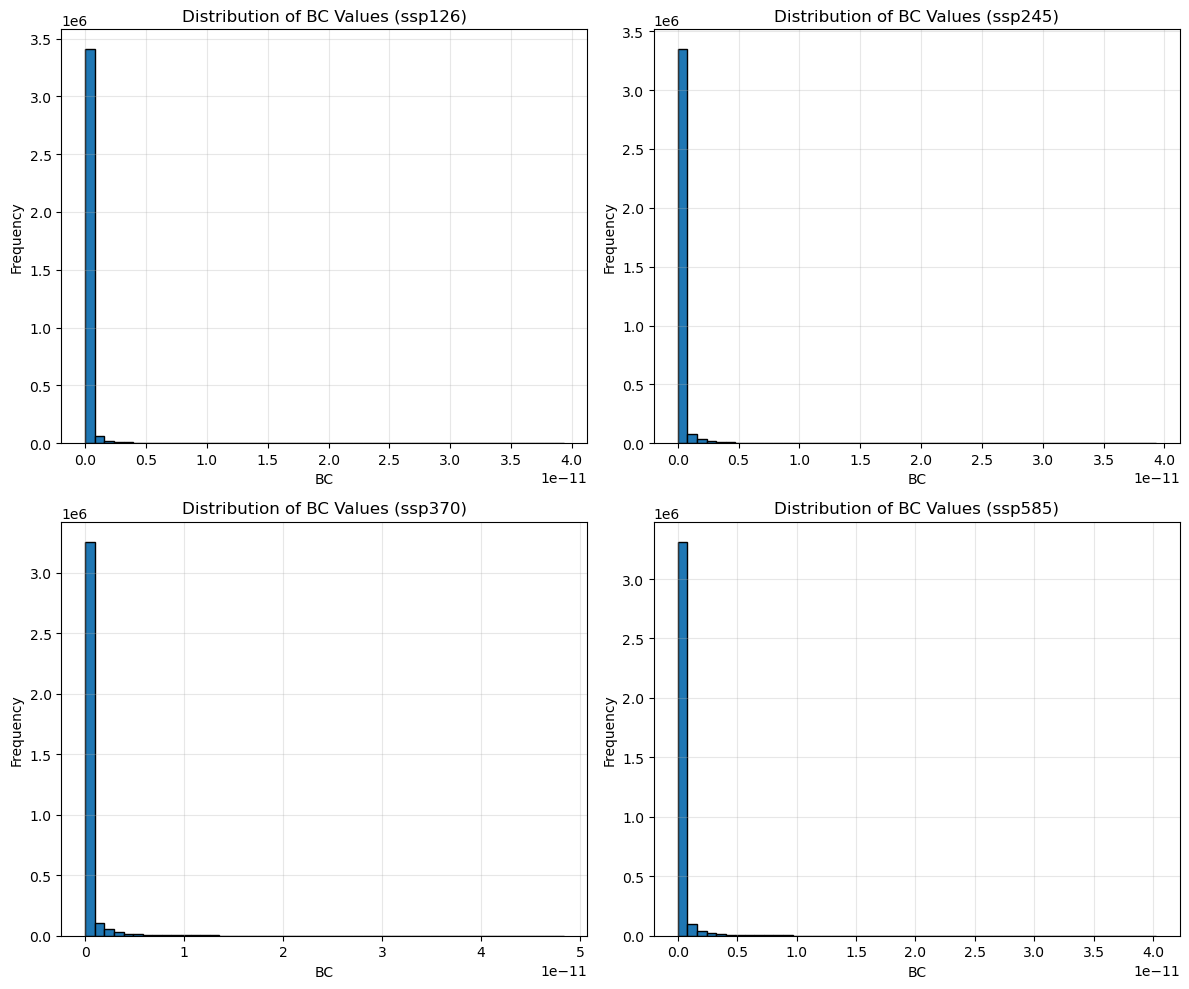

In [59]:
ssps = dfs['BC']['ssp'].unique()

# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot histogram for each SSP in its own subplot
for i, ssp in enumerate(ssps):
    ssp_data = np.array(dfs['BC'][dfs['BC']['ssp'] == ssp]['BC'])
    axes[i].hist(ssp_data, bins=50, edgecolor='black', linewidth=1)
    axes[i].set_title(f'Distribution of BC Values ({ssp})')
    axes[i].set_xlabel('BC')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

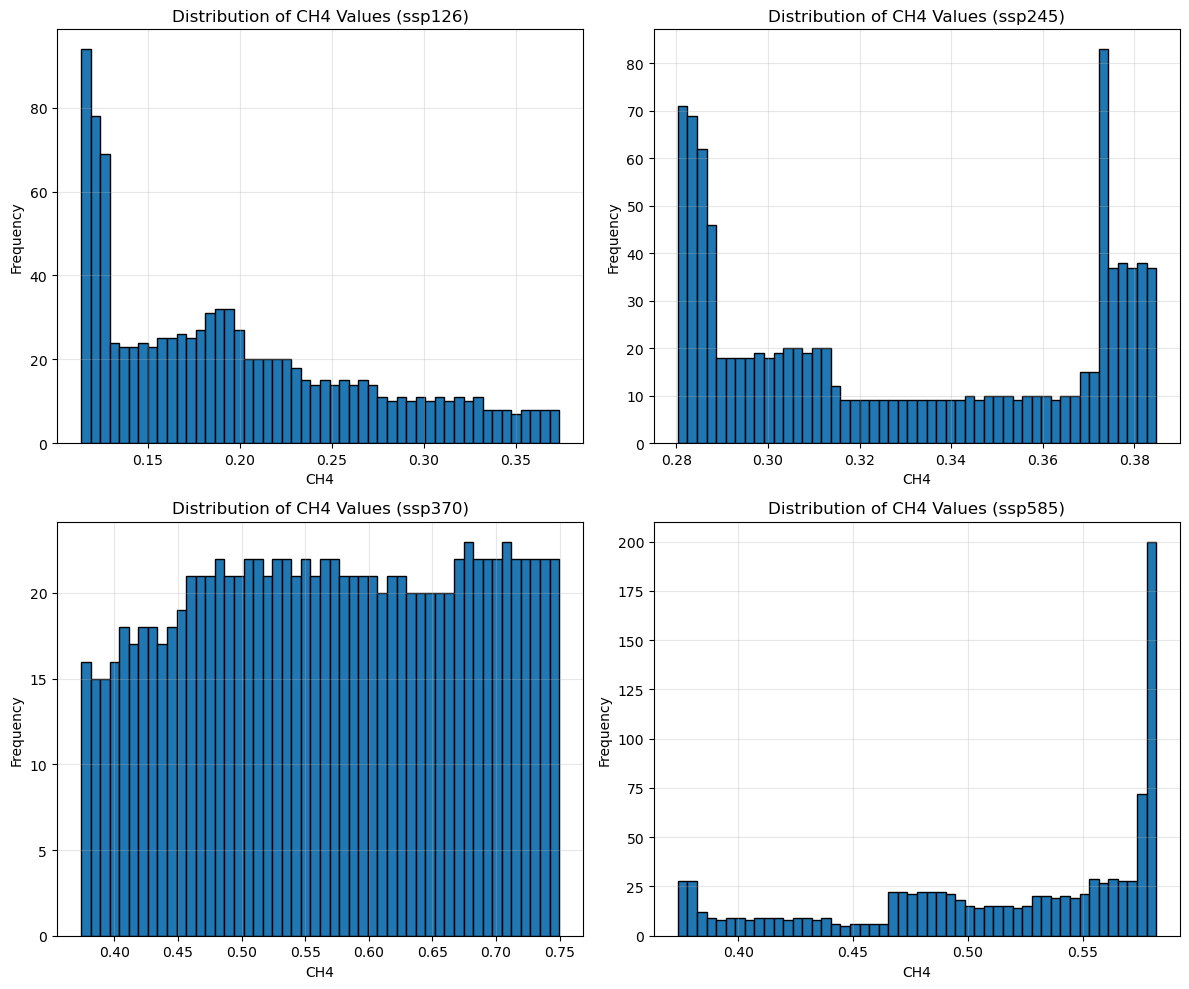

In [60]:
ssps = dfs['CH4']['ssp'].unique()

# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot histogram for each SSP in its own subplot
for i, ssp in enumerate(ssps):
    ssp_data = np.array(dfs['CH4'][dfs['CH4']['ssp'] == ssp]['CH4'])
    axes[i].hist(ssp_data, bins=50, edgecolor='black', linewidth=1)
    axes[i].set_title(f'Distribution of CH4 Values ({ssp})')
    axes[i].set_xlabel('CH4')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

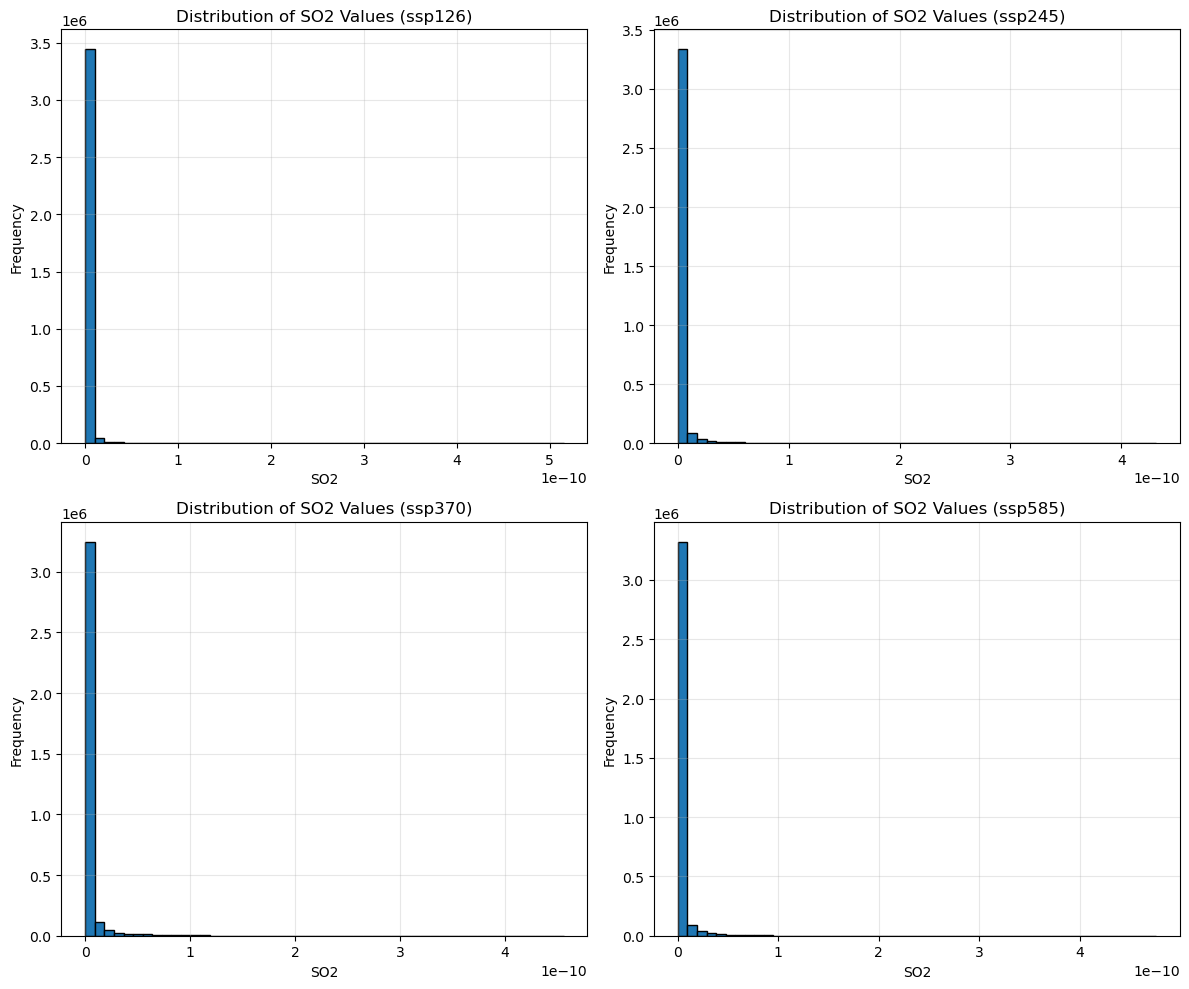

In [61]:
ssps = dfs['SO2']['ssp'].unique()

# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot histogram for each SSP in its own subplot
for i, ssp in enumerate(ssps):
    ssp_data = np.array(dfs['SO2'][dfs['SO2']['ssp'] == ssp]['SO2'])
    axes[i].hist(ssp_data, bins=50, edgecolor='black', linewidth=1)
    axes[i].set_title(f'Distribution of SO2 Values ({ssp})')
    axes[i].set_xlabel('SO2')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

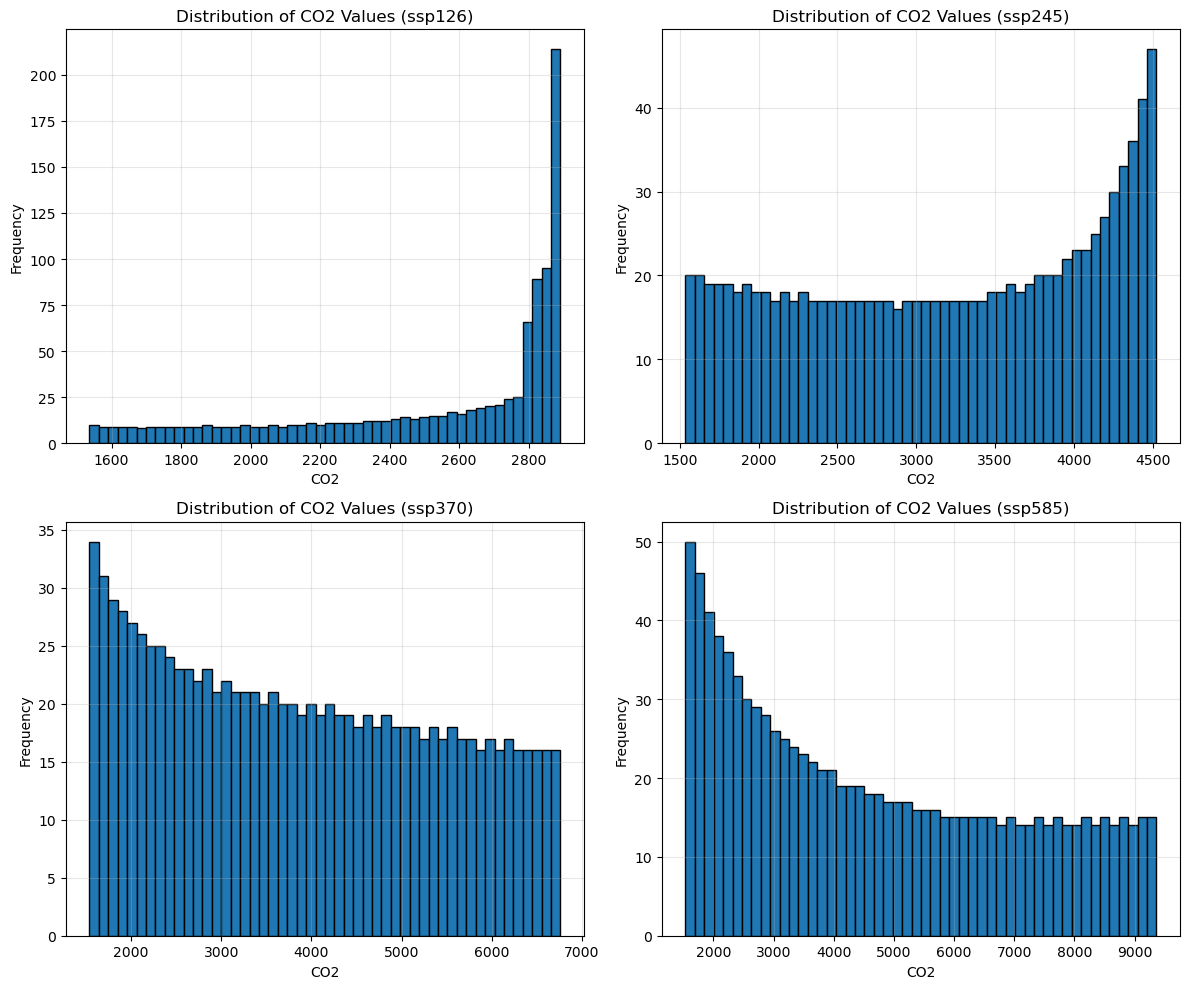

In [62]:
ssps = dfs['CO2']['ssp'].unique()

# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot histogram for each SSP in its own subplot
for i, ssp in enumerate(ssps):
    ssp_data = np.array(dfs['CO2'][dfs['CO2']['ssp'] == ssp]['CO2'])
    axes[i].hist(ssp_data, bins=50, edgecolor='black', linewidth=1)
    axes[i].set_title(f'Distribution of CO2 Values ({ssp})')
    axes[i].set_xlabel('CO2')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Distribution of Input Variables as a function of month

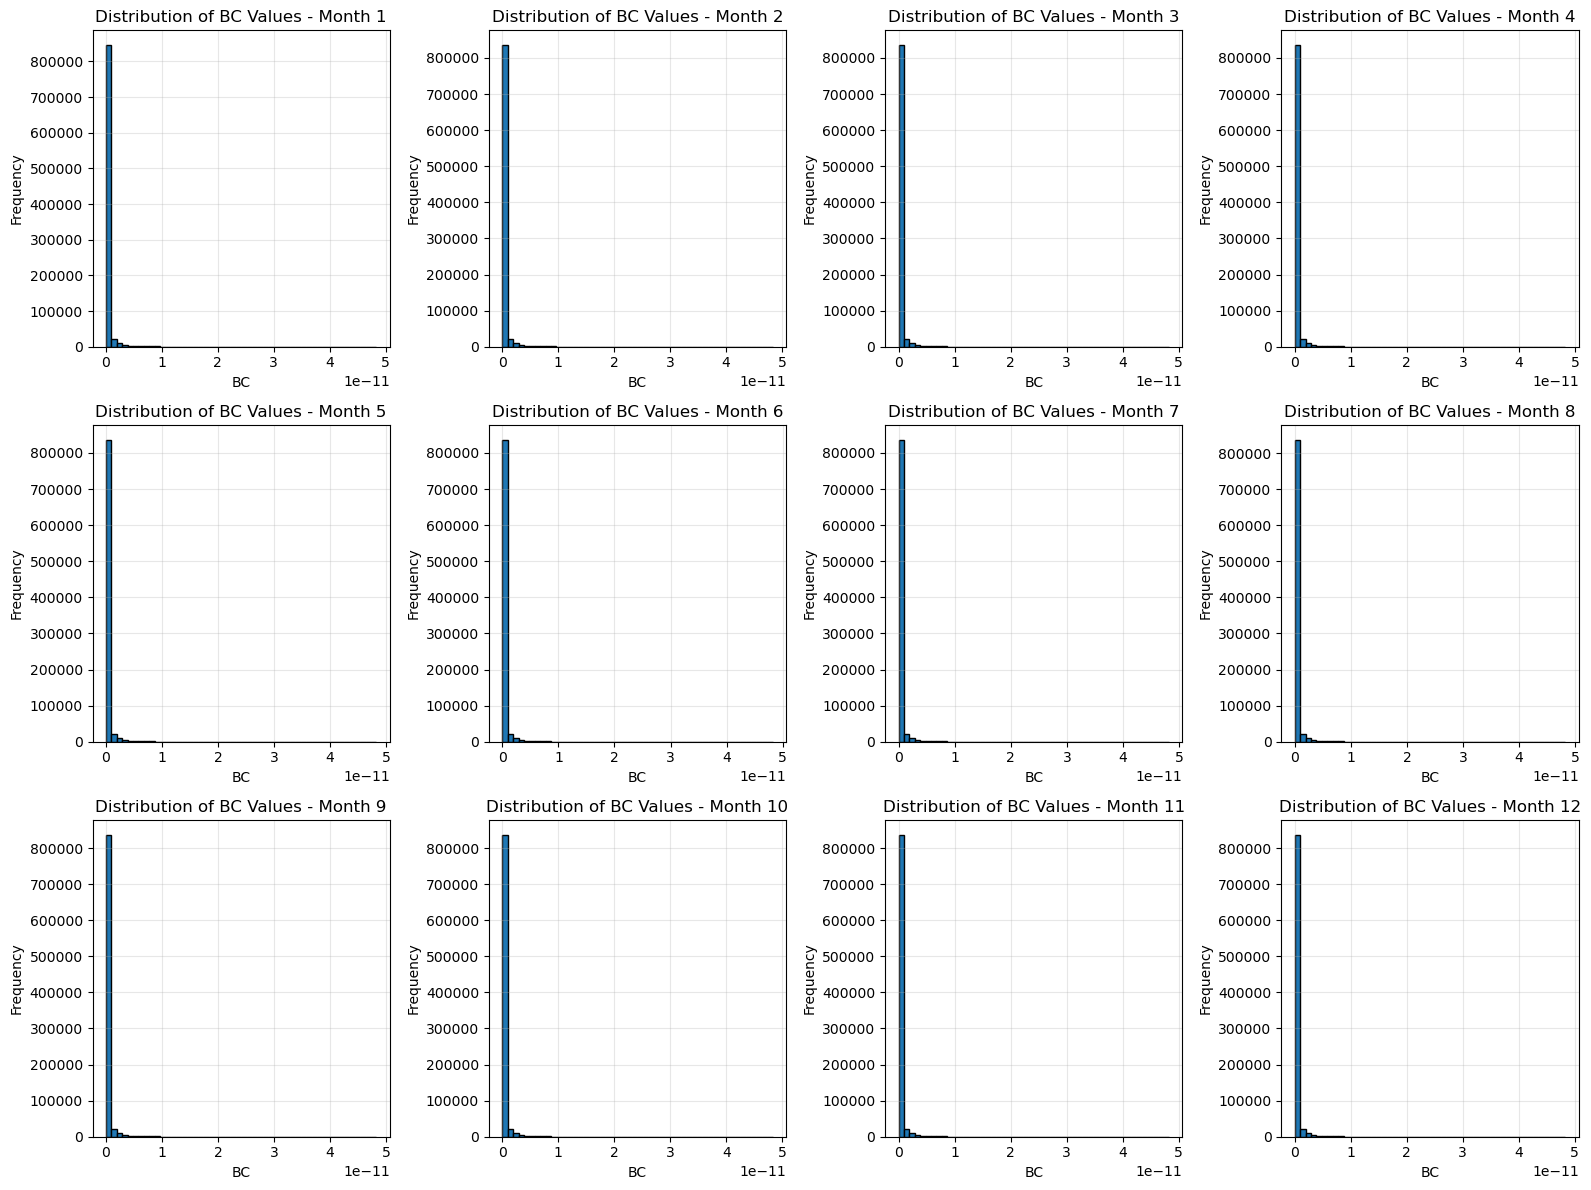

In [63]:
# Extract month directly from the DatetimeNoLeap objects
dfs['BC']['month'] = [time.month for time in dfs['BC']['time']]

# Create a figure with 12 subplots (one for each month)
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

# Plot histogram for each month
for month in range(1, 13):
    ax = axes[month-1]
    month_data = dfs['BC'][(dfs['BC']['ssp'] != 'ssp245') & (dfs['BC']['month'] == month)]
    
    ax.hist(np.array(month_data['BC']), bins=50, edgecolor='black', linewidth=1)
    ax.set_title(f'Distribution of BC Values - Month {month}')
    ax.set_xlabel('BC')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

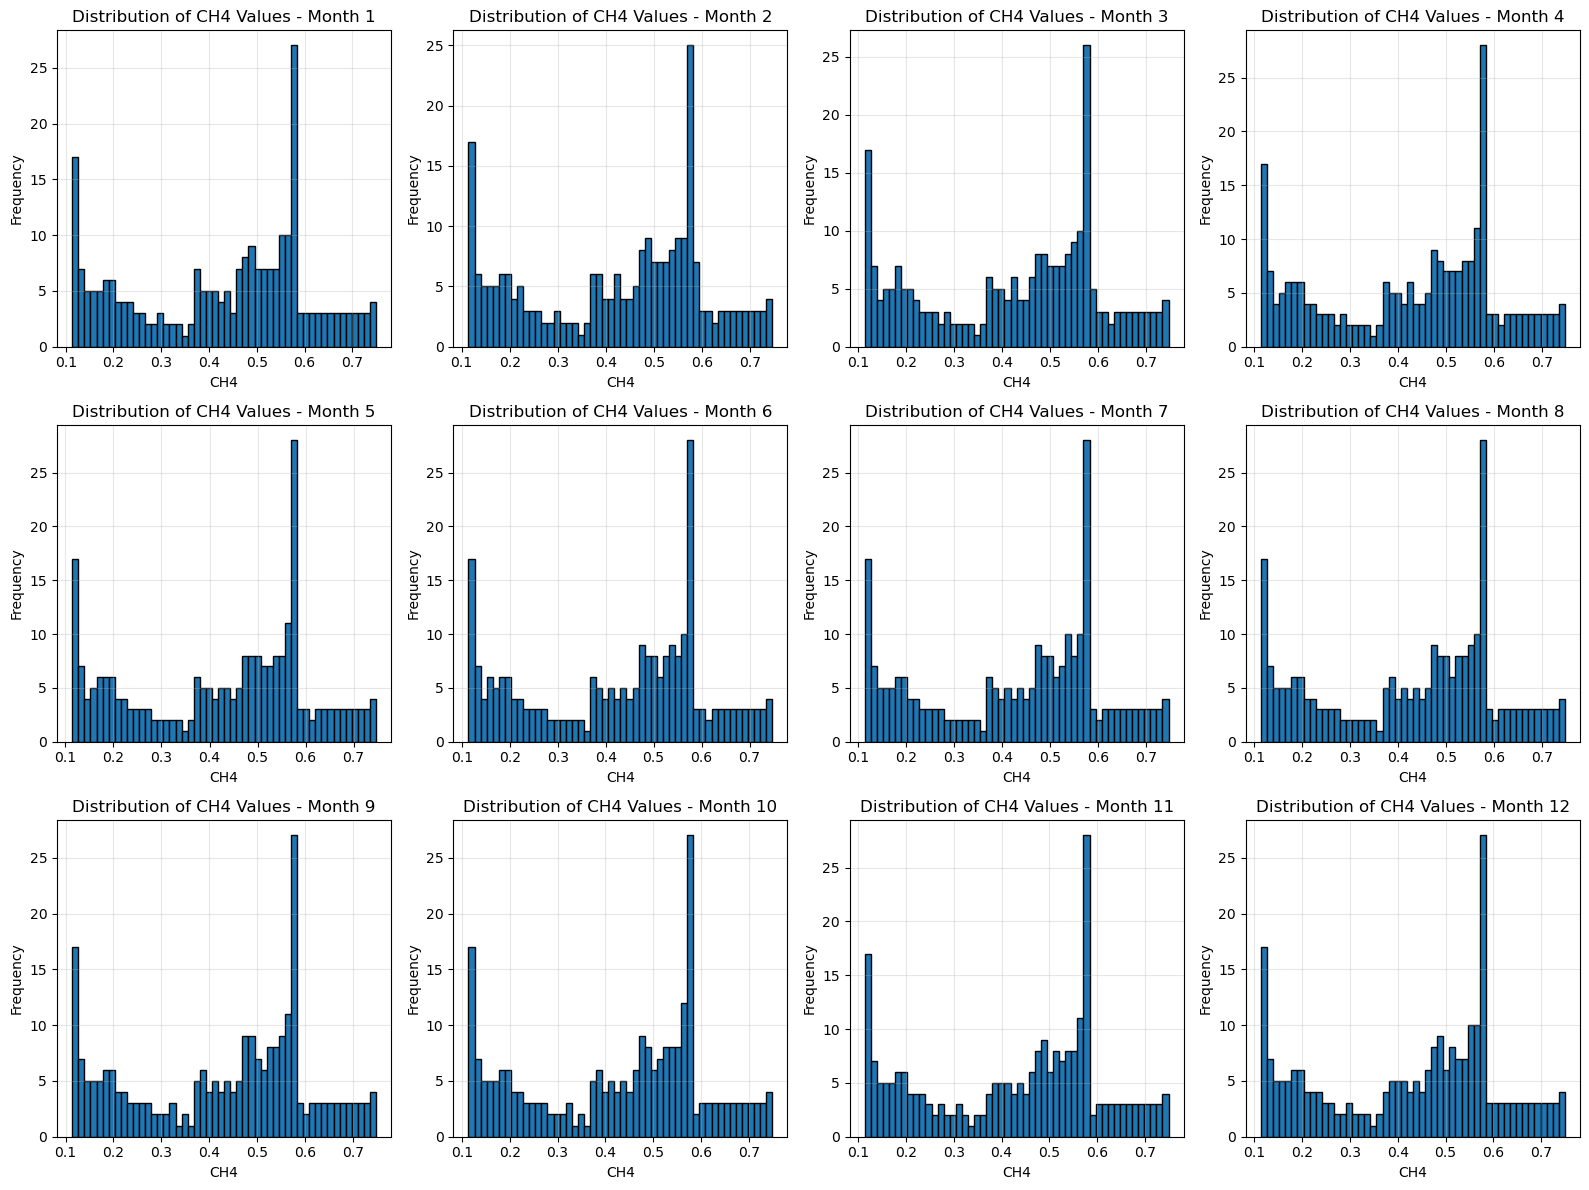

In [64]:
# Extract month directly from the DatetimeNoLeap objects
dfs['CH4']['month'] = [time.month for time in dfs['CH4']['time']]

# Create a figure with 12 subplots (one for each month)
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

# Plot histogram for each month
for month in range(1, 13):
    ax = axes[month-1]
    month_data = dfs['CH4'][(dfs['CH4']['ssp'] != 'ssp245') & (dfs['CH4']['month'] == month)]
    
    ax.hist(np.array(month_data['CH4']), bins=50, edgecolor='black', linewidth=1)
    ax.set_title(f'Distribution of CH4 Values - Month {month}')
    ax.set_xlabel('CH4')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

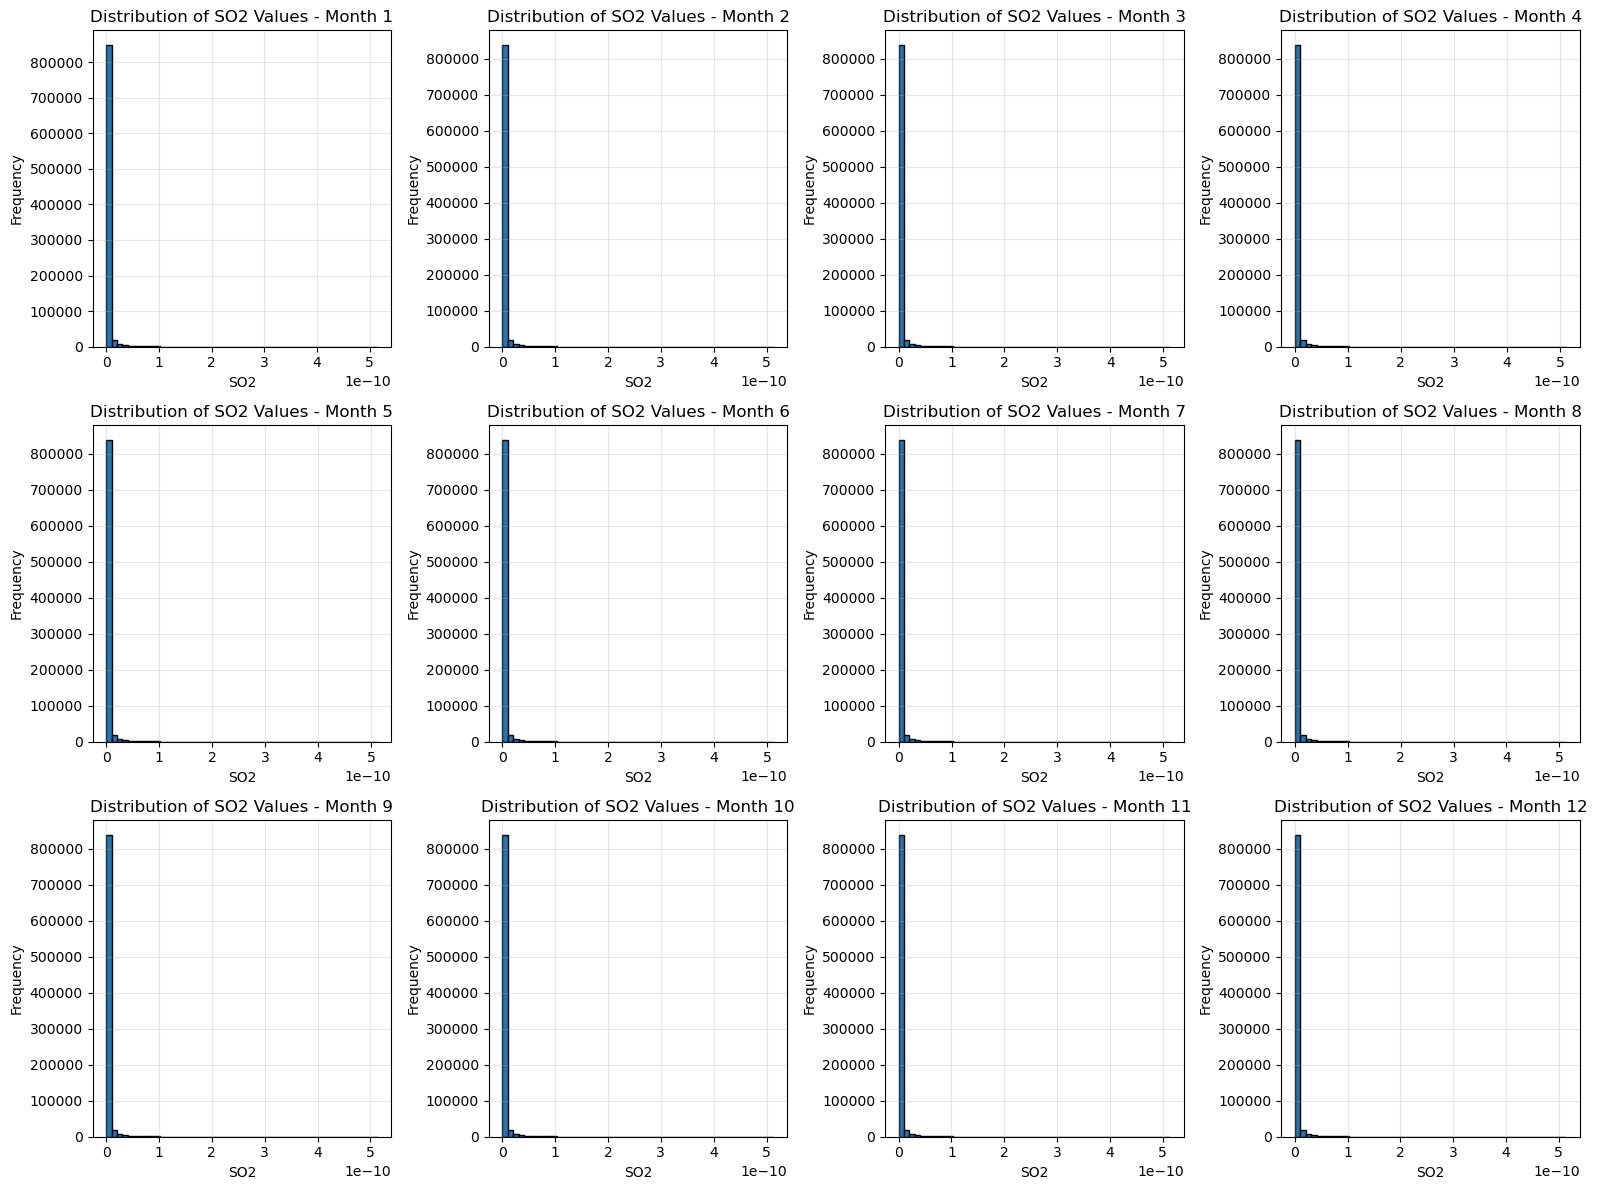

In [65]:
# Extract month directly from the DatetimeNoLeap objects
dfs['SO2']['month'] = [time.month for time in dfs['SO2']['time']]

# Create a figure with 12 subplots (one for each month)
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

# Plot histogram for each month
for month in range(1, 13):
    ax = axes[month-1]
    month_data = dfs['SO2'][(dfs['SO2']['ssp'] != 'ssp245') & (dfs['SO2']['month'] == month)]
    
    ax.hist(np.array(month_data['SO2']), bins=50, edgecolor='black', linewidth=1)
    ax.set_title(f'Distribution of SO2 Values - Month {month}')
    ax.set_xlabel('SO2')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

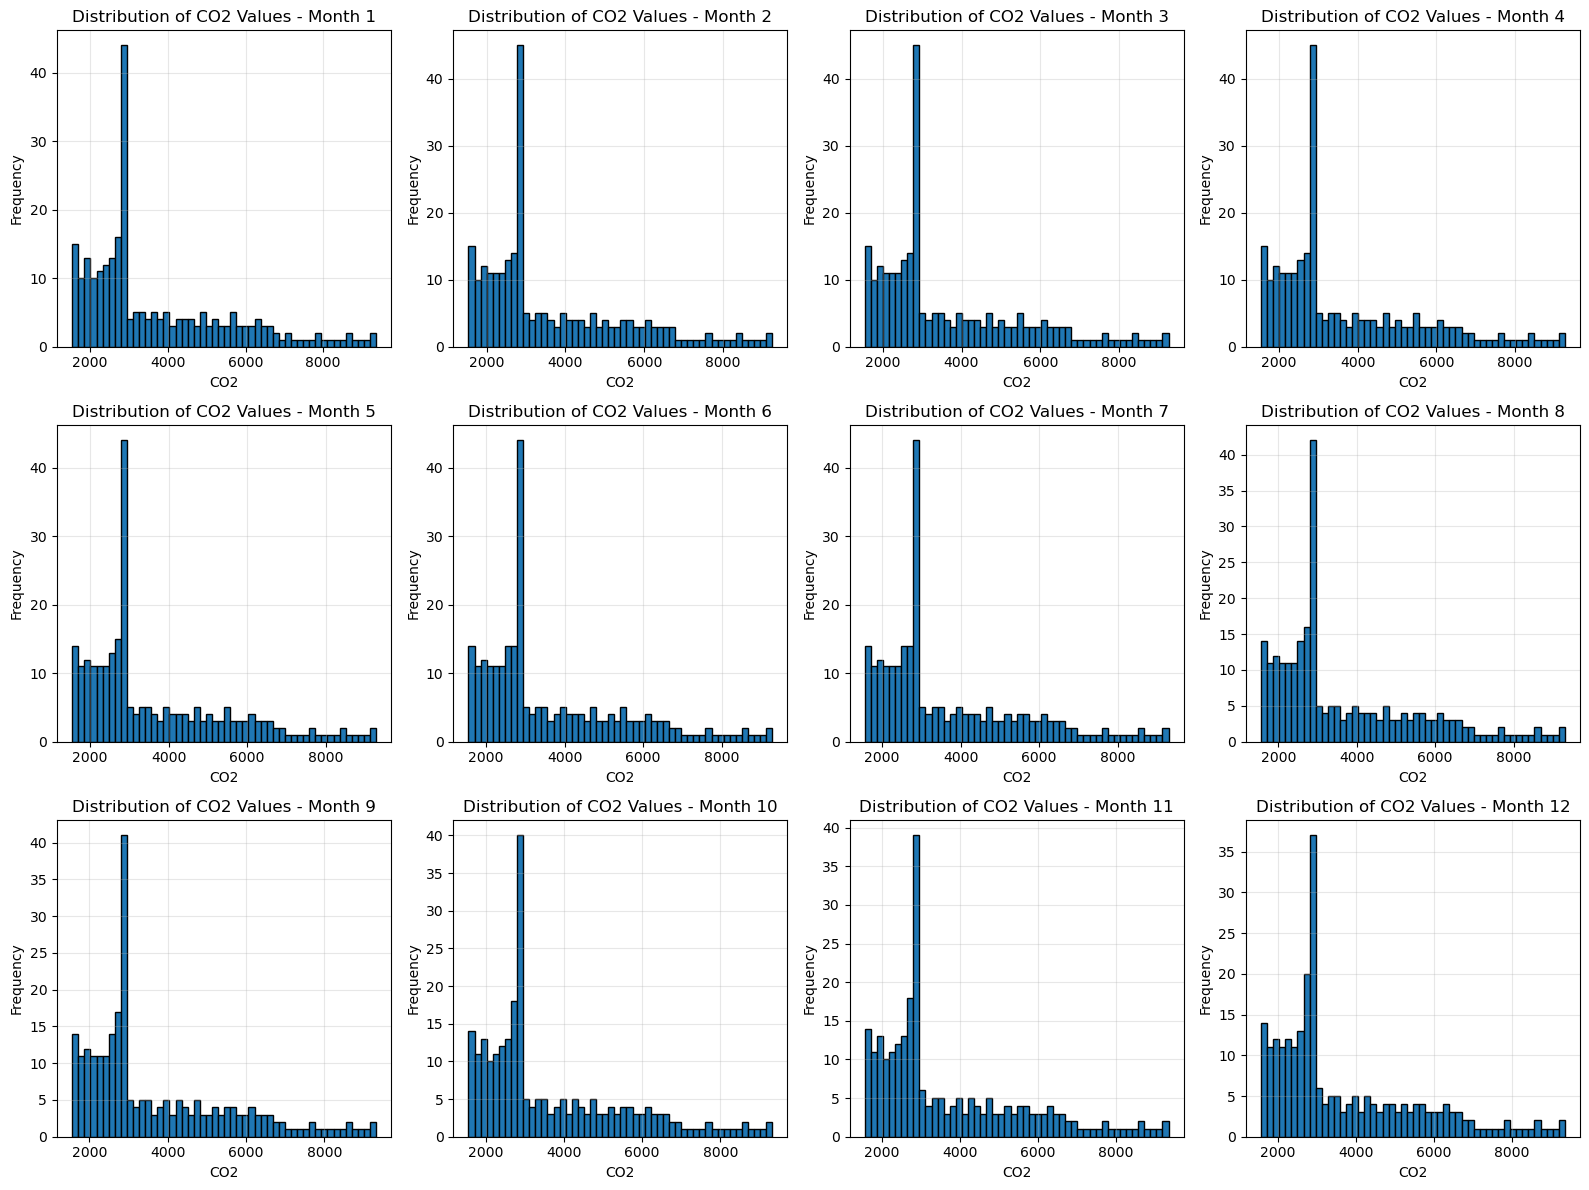

In [66]:
# Extract month directly from the DatetimeNoLeap objects
dfs['CO2']['month'] = [time.month for time in dfs['CO2']['time']]

# Create a figure with 12 subplots (one for each month)
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

# Plot histogram for each month
for month in range(1, 13):
    ax = axes[month-1]
    month_data = dfs['CO2'][(dfs['CO2']['ssp'] != 'ssp245') & (dfs['CO2']['month'] == month)]
    
    ax.hist(np.array(month_data['CO2']), bins=50, edgecolor='black', linewidth=1)
    ax.set_title(f'Distribution of CO2 Values - Month {month}')
    ax.set_xlabel('CO2')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

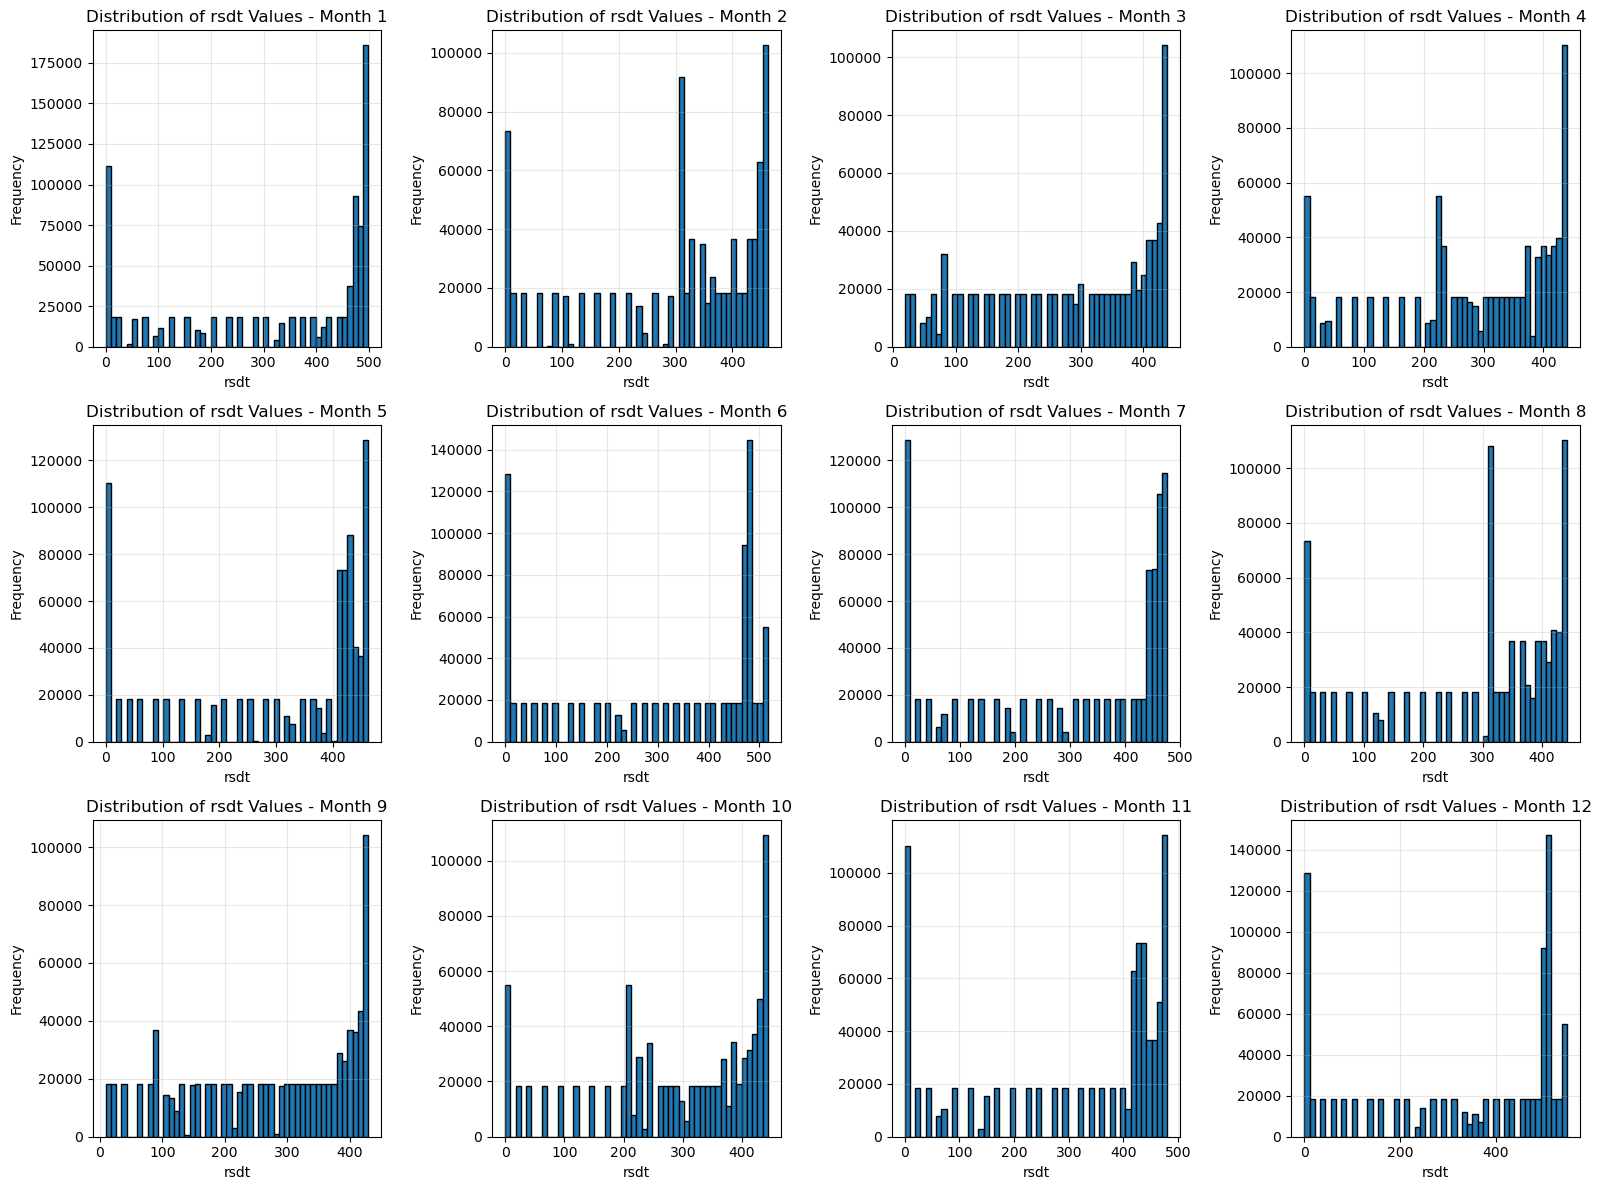

In [68]:
# Extract month directly from the DatetimeNoLeap objects
dfs['rsdt']['month'] = [time.month for time in dfs['rsdt']['time']]

# Create a figure with 12 subplots (one for each month)
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

# Plot histogram for each month
for month in range(1, 13):
    ax = axes[month-1]
    month_data = dfs['rsdt'][(dfs['rsdt']['ssp'] != 'ssp245') & (dfs['rsdt']['month'] == month)]
    
    ax.hist(np.array(month_data['rsdt']), bins=50, edgecolor='black', linewidth=1)
    ax.set_title(f'Distribution of rsdt Values - Month {month}')
    ax.set_xlabel('rsdt')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [33]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from torch.utils.data import Subset, DataLoader
import seaborn as sns
from tqdm.notebook import tqdm

class LossAnalyzer:
    def __init__(self, datamodule, model, criterion=None):
        """
        Initialize the loss analyzer with a datamodule and model.
        
        Args:
            datamodule: The ClimateDataModule containing the data
            model: The trained PyTorch model
            criterion: Loss function (defaults to MSE if None)
        """
        self.datamodule = datamodule
        self.model = model
        self.criterion = criterion or torch.nn.MSELoss(reduction='none')
        self.device = next(model.parameters()).device
        self.normalizer = datamodule.normalizer
        
        # Get the full training dataset
        self.train_dataset = datamodule.train_dataset
        self.lat, self.lon = datamodule.get_coords()
        self.area_weights = datamodule.get_lat_weights()
        
        # Store variable names
        self.input_vars = datamodule.input_vars
        self.output_vars = datamodule.output_vars
        
    def compute_sample_losses(self, indices=None, batch_size=32):
        """
        Compute per-sample losses for the specified indices or the entire dataset.
        
        Args:
            indices: Optional list of indices to compute losses for
            batch_size: Batch size for inference
            
        Returns:
            Dictionary with sample losses and metadata
        """
        if indices is None:
            dataset = self.train_dataset
        else:
            dataset = Subset(self.train_dataset, indices)
            
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        
        all_losses = []
        all_inputs = []
        all_outputs = []
        all_predictions = []
        
        self.model.eval()
        with torch.no_grad():
            for inputs, targets in tqdm(dataloader, desc="Computing losses"):
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                
                # Forward pass
                predictions = self.model(inputs)
                
                # Compute loss per sample and per output variable
                losses = self.criterion(predictions, targets)  # Shape: [batch, channels, height, width]
                
                # Compute spatial mean loss per sample and channel
                sample_losses = losses.mean(dim=(2, 3))  # Shape: [batch, channels]
                
                # Store results
                all_losses.append(sample_losses.cpu().numpy())
                all_inputs.append(inputs.cpu().numpy())
                all_outputs.append(targets.cpu().numpy())
                all_predictions.append(predictions.cpu().numpy())
        
        # Concatenate results
        all_losses = np.concatenate(all_losses, axis=0)
        all_inputs = np.concatenate(all_inputs, axis=0)
        all_outputs = np.concatenate(all_outputs, axis=0)
        all_predictions = np.concatenate(all_predictions, axis=0)
        
        # Create result dictionary
        result = {
            'losses': all_losses,  # Shape: [n_samples, n_output_vars]
            'total_loss': all_losses.mean(axis=1),  # Mean loss across output variables
            'inputs': all_inputs,  # Shape: [n_samples, n_input_vars, height, width]
            'outputs': all_outputs,  # Shape: [n_samples, n_output_vars, height, width]
            'predictions': all_predictions,  # Shape: [n_samples, n_output_vars, height, width]
            'indices': indices if indices is not None else np.arange(len(dataset))
        }
        
        return result
    
    def sample_by_criteria(self, criteria, n_samples=100):
        """
        Sample indices based on different criteria.
        
        Args:
            criteria: String indicating sampling method ('random', 'stratified', 'time_based', etc.)
            n_samples: Number of samples to select
            
        Returns:
            List of selected indices
        """
        n_total = len(self.train_dataset)
        
        if criteria == 'random':
            # Random sampling
            return np.random.choice(n_total, size=n_samples, replace=False)
        
        elif criteria == 'stratified_by_ssp':
            # Get SSP information for each sample
            # This requires accessing the original data
            # You'll need to modify this based on how your data is structured
            ssps = []
            for i in range(n_total):
                # Get SSP for sample i
                # This is a placeholder - you need to implement this
                ssp = "unknown"  # Replace with actual code to get SSP
                ssps.append(ssp)
            
            # Stratify by SSP
            unique_ssps = np.unique(ssps)
            samples_per_ssp = n_samples // len(unique_ssps)
            
            indices = []
            for ssp in unique_ssps:
                ssp_indices = np.where(np.array(ssps) == ssp)[0]
                selected = np.random.choice(ssp_indices, size=samples_per_ssp, replace=False)
                indices.extend(selected)
            
            return indices
        
        elif criteria == 'time_based':
            # Sample evenly across time
            # This assumes samples are ordered by time
            step = n_total // n_samples
            return np.arange(0, n_total, step)[:n_samples]
        
        elif criteria == 'spatial_regions':
            # Sample different spatial regions
            # This is a placeholder - implement based on your needs
            regions = [
                {'lat_range': (-90, -30), 'lon_range': (0, 360)},  # Southern high latitudes
                {'lat_range': (-30, 30), 'lon_range': (0, 360)},   # Tropics
                {'lat_range': (30, 90), 'lon_range': (0, 360)}     # Northern high latitudes
            ]
            
            # You'll need to implement logic to select samples from these regions
            # This is just a placeholder
            return np.random.choice(n_total, size=n_samples, replace=False)
        
        else:
            raise ValueError(f"Unknown sampling criteria: {criteria}")
    
    def analyze_high_loss_samples(self, result, top_n=20, variable_idx=None):
        """
        Analyze the samples with highest loss.
        
        Args:
            result: Result dictionary from compute_sample_losses
            top_n: Number of highest-loss samples to analyze
            variable_idx: Index of output variable to focus on (None for total loss)
            
        Returns:
            Dictionary with analysis results
        """
        if variable_idx is None:
            # Use total loss across all variables
            losses = result['total_loss']
            var_name = "total"
        else:
            # Use loss for specific variable
            losses = result['losses'][:, variable_idx]
            var_name = self.output_vars[variable_idx]
        
        # Get indices of highest-loss samples
        top_indices = np.argsort(losses)[-top_n:][::-1]
        
        # Get original dataset indices
        original_indices = result['indices'][top_indices]
        
        # Get corresponding losses, inputs, outputs, and predictions
        top_losses = losses[top_indices]
        top_inputs = result['inputs'][top_indices]
        top_outputs = result['outputs'][top_indices]
        top_predictions = result['predictions'][top_indices]
        
        # Create analysis result
        analysis = {
            'variable': var_name,
            'indices': original_indices,
            'losses': top_losses,
            'inputs': top_inputs,
            'outputs': top_outputs,
            'predictions': top_predictions
        }
        
        return analysis
    
    def visualize_high_loss_samples(self, analysis, n_samples=5):
        """
        Visualize high-loss samples.
        
        Args:
            analysis: Analysis result from analyze_high_loss_samples
            n_samples: Number of samples to visualize
        """
        n_samples = min(n_samples, len(analysis['indices']))
        var_name = analysis['variable']
        
        for i in range(n_samples):
            idx = i
            loss = analysis['losses'][idx]
            
            # Get data for visualization
            if var_name == "total":
                # For total loss, visualize all output variables
                for v_idx, v_name in enumerate(self.output_vars):
                    output = analysis['outputs'][idx, v_idx]
                    prediction = analysis['predictions'][idx, v_idx]
                    
                    # Create xarray DataArrays for plotting
                    output_xr = xr.DataArray(output, dims=["y", "x"], 
                                            coords={"y": self.lat, "x": self.lon})
                    pred_xr = xr.DataArray(prediction, dims=["y", "x"], 
                                          coords={"y": self.lat, "x": self.lon})
                    
                    # Denormalize if needed
                    if hasattr(self.normalizer, 'inverse_transform_output'):
                        output_denorm = self.normalizer.inverse_transform_output(
                            output.reshape(1, 1, *output.shape))[0, 0]
                        pred_denorm = self.normalizer.inverse_transform_output(
                            prediction.reshape(1, 1, *prediction.shape))[0, 0]
                        
                        output_xr = xr.DataArray(output_denorm, dims=["y", "x"], 
                                               coords={"y": self.lat, "x": self.lon})
                        pred_xr = xr.DataArray(pred_denorm, dims=["y", "x"], 
                                             coords={"y": self.lat, "x": self.lon})
                    
                    # Plot
                    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
                    
                    # Ground truth
                    output_xr.plot(ax=axs[0], cmap='viridis')
                    axs[0].set_title(f"{v_name} - Ground Truth")
                    
                    # Prediction
                    pred_xr.plot(ax=axs[1], cmap='viridis')
                    axs[1].set_title(f"{v_name} - Prediction")
                    
                    # Difference
                    diff = pred_xr - output_xr
                    diff.plot(ax=axs[2], cmap='RdBu_r')
                    axs[2].set_title(f"{v_name} - Difference")
                    
                    plt.suptitle(f"Sample {analysis['indices'][idx]}, Loss: {loss:.4f}")
                    plt.tight_layout()
                    plt.show()
            else:
                # For specific variable
                v_idx = self.output_vars.index(var_name)
                output = analysis['outputs'][idx, v_idx]
                prediction = analysis['predictions'][idx, v_idx]
                
                # Create xarray DataArrays for plotting
                output_xr = xr.DataArray(output, dims=["y", "x"], 
                                        coords={"y": self.lat, "x": self.lon})
                pred_xr = xr.DataArray(prediction, dims=["y", "x"], 
                                      coords={"y": self.lat, "x": self.lon})
                
                # Denormalize if needed
                if hasattr(self.normalizer, 'inverse_transform_output'):
                    output_denorm = self.normalizer.inverse_transform_output(
                        output.reshape(1, 1, *output.shape))[0, 0]
                    pred_denorm = self.normalizer.inverse_transform_output(
                        prediction.reshape(1, 1, *prediction.shape))[0, 0]
                    
                    output_xr = xr.DataArray(output_denorm, dims=["y", "x"], 
                                           coords={"y": self.lat, "x": self.lon})
                    pred_xr = xr.DataArray(pred_denorm, dims=["y", "x"], 
                                         coords={"y": self.lat, "x": self.lon})
                
                # Plot
                fig, axs = plt.subplots(1, 3, figsize=(18, 5))
                
                # Ground truth
                output_xr.plot(ax=axs[0], cmap='viridis')
                axs[0].set_title(f"{var_name} - Ground Truth")
                
                # Prediction
                pred_xr.plot(ax=axs[1], cmap='viridis')
                axs[1].set_title(f"{var_name} - Prediction")
                
                # Difference
                diff = pred_xr - output_xr
                diff.plot(ax=axs[2], cmap='RdBu_r')
                axs[2].set_title(f"{var_name} - Difference")
                
                plt.suptitle(f"Sample {analysis['indices'][idx]}, Loss: {loss:.4f}")
                plt.tight_layout()
                plt.show()
    
    def cluster_by_loss_patterns(self, result, n_clusters=5):
        """
        Cluster samples based on their loss patterns across space.
        
        Args:
            result: Result dictionary from compute_sample_losses
            n_clusters: Number of clusters to create
            
        Returns:
            Dictionary with clustering results
        """
        # Compute spatial loss patterns
        predictions = result['predictions']
        outputs = result['outputs']
        
        # Compute loss per pixel
        pixel_losses = (predictions - outputs)**2
        
        # Reshape to [n_samples, n_pixels * n_vars]
        n_samples, n_vars, height, width = pixel_losses.shape
        reshaped_losses = pixel_losses.reshape(n_samples, -1)
        
        # Apply PCA for dimensionality reduction
        pca = PCA(n_components=min(50, reshaped_losses.shape[1]))
        reduced_losses = pca.fit_transform(reshaped_losses)
        
        # Cluster the loss patterns
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(reduced_losses)
        
        # Compute average loss per cluster
        cluster_losses = []
        for i in range(n_clusters):
            mask = clusters == i
            avg_loss = result['total_loss'][mask].mean()
            cluster_losses.append(avg_loss)
        
        # Create clustering result
        clustering = {
            'clusters': clusters,
            'cluster_losses': cluster_losses,
            'indices': result['indices'],
            'reduced_losses': reduced_losses
        }
        
        return clustering
    
    def visualize_clusters(self, clustering):
        """
        Visualize the clustering results.
        
        Args:
            clustering: Clustering result from cluster_by_loss_patterns
        """
        clusters = clustering['clusters']
        reduced_losses = clustering['reduced_losses']
        cluster_losses = clustering['cluster_losses']
        
        # Create a scatter plot of the first two PCA components
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(reduced_losses[:, 0], reduced_losses[:, 1], 
                             c=clusters, cmap='viridis', alpha=0.7)
        
        # Add cluster centers
        for i in range(len(cluster_losses)):
            mask = clusters == i
            center_x = reduced_losses[mask, 0].mean()
            center_y = reduced_losses[mask, 1].mean()
            plt.annotate(f"Cluster {i}\nLoss: {cluster_losses[i]:.4f}",
                        (center_x, center_y),
                        fontsize=12, fontweight='bold')
        
        plt.colorbar(scatter, label='Cluster')
        plt.title('Clustering of Samples by Loss Patterns')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Plot average loss per cluster
        plt.figure(figsize=(10, 6))
        bars = plt.bar(range(len(cluster_losses)), cluster_losses)
        
        # Add count of samples per cluster
        for i in range(len(cluster_losses)):
            count = np.sum(clusters == i)
            plt.annotate(f"n={count}",
                        (i, cluster_losses[i]),
                        ha='center', va='bottom')
        
        plt.xlabel('Cluster')
        plt.ylabel('Average Loss')
        plt.title('Average Loss per Cluster')
        plt.xticks(range(len(cluster_losses)))
        plt.grid(True, axis='y', alpha=0.3)
        plt.show()
    
    def analyze_loss_by_region(self, result):
        """
        Analyze loss patterns by geographical region.
        
        Args:
            result: Result dictionary from compute_sample_losses
            
        Returns:
            Dictionary with regional analysis
        """
        predictions = result['predictions']
        outputs = result['outputs']
        
        # Compute loss per pixel
        pixel_losses = (predictions - outputs)**2  # Shape: [n_samples, n_vars, height, width]
        
        # Define regions (latitude bands)
        regions = [
            {'name': 'Arctic', 'lat_range': (66.5, 90)},
            {'name': 'Northern Mid-Latitudes', 'lat_range': (30, 66.5)},
            {'name': 'Tropics', 'lat_range': (-30, 30)},
            {'name': 'Southern Mid-Latitudes', 'lat_range': (-66.5, -30)},
            {'name': 'Antarctic', 'lat_range': (-90, -66.5)}
        ]
        
        # Compute average loss per region
        region_losses = []
        for region in regions:
            lat_min, lat_max = region['lat_range']
            
            # Find latitude indices within the range
            lat_indices = np.where((self.lat >= lat_min) & (self.lat <= lat_max))[0]
            
            if len(lat_indices) == 0:
                continue
                
            # Compute average loss in this region
            region_loss = pixel_losses[:, :, lat_indices, :].mean(axis=(0, 2, 3))
            
            region_losses.append({
                'name': region['name'],
                'lat_range': region['lat_range'],
                'loss': region_loss,
                'total_loss': region_loss.mean()
            })
        
        return {'regions': region_losses}
    
    def visualize_regional_analysis(self, regional_analysis):
        """
        Visualize the regional loss analysis.
        
        Args:
            regional_analysis: Result from analyze_loss_by_region
        """
        regions = regional_analysis['regions']
        
        # Plot total loss by region
        plt.figure(figsize=(12, 6))
        names = [r['name'] for r in regions]
        losses = [r['total_loss'] for r in regions]
        
        bars = plt.bar(names, losses)
        
        plt.xlabel('Region')
        plt.ylabel('Average Loss')
        plt.title('Average Loss by Geographical Region')
        plt.xticks(rotation=45)
        plt.grid(True, axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Plot loss by variable and region
        if len(self.output_vars) > 1:
            plt.figure(figsize=(14, 8))
            
            x = np.arange(len(regions))
            width = 0.8 / len(self.output_vars)
            
            for i, var in enumerate(self.output_vars):
                var_losses = [r['loss'][i] for r in regions]
                offset = (i - len(self.output_vars)/2 + 0.5) * width
                plt.bar(x + offset, var_losses, width, label=var)
            
            plt.xlabel('Region')
            plt.ylabel('Average Loss')
            plt.title('Average Loss by Variable and Region')
            plt.xticks(x, names, rotation=45)
            plt.legend()
            plt.grid(True, axis='y', alpha=0.3)
            plt.tight_layout()
            plt.show()

# Example usage
def run_loss_analysis(datamodule, model, sample_size=500):
    """
    Run a complete loss analysis workflow.
    
    Args:
        datamodule: The ClimateDataModule
        model: The trained model
        sample_size: Number of samples to analyze
    """
    analyzer = LossAnalyzer(datamodule, model)
    
    # Sample random subset
    print(f"Sampling {sample_size} random samples...")
    indices = analyzer.sample_by_criteria('random', n_samples=sample_size)
    
    # Compute losses
    print("Computing losses...")
    result = analyzer.compute_sample_losses(indices)
    
    # Analyze high-loss samples
    print("Analyzing high-loss samples...")
    analysis = analyzer.analyze_high_loss_samples(result, top_n=10)
    
    # Visualize high-loss samples
    print("Visualizing high-loss samples...")
    analyzer.visualize_high_loss_samples(analysis, n_samples=3)
    
    # Cluster by loss patterns
    print("Clustering samples by loss patterns...")
    clustering = analyzer.cluster_by_loss_patterns(result, n_clusters=5)
    
    # Visualize clusters
    print("Visualizing clusters...")
    analyzer.visualize_clusters(clustering)
    
    # Analyze by region
    print("Analyzing loss by region...")
    regional_analysis = analyzer.analyze_loss_by_region(result)
    
    # Visualize regional analysis
    print("Visualizing regional analysis...")
    analyzer.visualize_regional_analysis(regional_analysis)
    
    return {
        'result': result,
        'analysis': analysis,
        'clustering': clustering,
        'regional_analysis': regional_analysis
    }

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class ClimateXGBoostPredictor:
    """
    A class to predict climate variables (pr and tas) using XGBoost regressors.
    This approach flattens spatial dimensions and treats each grid cell as a separate prediction task.
    """
    def __init__(self, n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8):
        """
        Initialize the XGBoost predictor with hyperparameters.
        
        Args:
            n_estimators: Number of boosting rounds
            max_depth: Maximum tree depth
            learning_rate: Step size shrinkage
            subsample: Subsample ratio of training instances
        """
        self.params = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'learning_rate': learning_rate,
            'subsample': subsample,
            'objective': 'reg:squarederror',
            'tree_method': 'hist',  # For faster training
            'verbosity': 1
        }
        
        # Create separate models for each output variable
        self.pr_model = xgb.XGBRegressor(**self.params)
        self.tas_model = xgb.XGBRegressor(**self.params)
        
        # Scalers for input and output normalization
        self.input_scaler = StandardScaler()
        self.pr_scaler = StandardScaler()
        self.tas_scaler = StandardScaler()
        
        # Store grid dimensions for reshaping predictions
        self.grid_shape = None
        self.input_vars = None
        self.lat = None
        self.lon = None
    
    def _prepare_data(self, ds, input_vars, output_vars=['pr', 'tas']):
        """
        Prepare data from xarray Dataset for XGBoost training.
        
        Args:
            ds: xarray Dataset containing climate data
            input_vars: List of input variable names
            output_vars: List of output variable names
            
        Returns:
            X: Input features (time, variables, lat, lon) reshaped to (time, variables*lat*lon)
            y_pr: Precipitation targets
            y_tas: Temperature targets
        """
        # Store input variables for prediction
        self.input_vars = input_vars
        
        # Extract coordinates
        self.lat = ds.lat.values
        self.lon = ds.lon.values
        
        # Store grid shape for reshaping predictions
        self.grid_shape = (len(self.lat), len(self.lon))
        
        # Extract input variables and stack them
        X_list = []
        for var in input_vars:
            if var in ds:
                # Handle different dimensions
                if 'lat' in ds[var].dims and 'lon' in ds[var].dims:
                    # Spatial variable
                    X_var = ds[var].values
                    # Reshape to (time, lat*lon)
                    X_var = X_var.reshape(X_var.shape[0], -1)
                else:
                    # Non-spatial variable (e.g., global forcing)
                    X_var = ds[var].values.reshape(-1, 1)
                    # Repeat for each grid cell
                    X_var = np.repeat(X_var, self.grid_shape[0] * self.grid_shape[1], axis=1)
                
                X_list.append(X_var)
        
        # Concatenate all input variables
        X = np.concatenate(X_list, axis=1)
        
        # Extract output variables
        y_pr = ds['pr'].values.reshape(ds['pr'].shape[0], -1)
        y_tas = ds['tas'].values.reshape(ds['tas'].shape[0], -1)
        
        return X, y_pr, y_tas
    
    def fit(self, ds, input_vars, output_vars=['pr', 'tas'], test_size=0.2):
        """
        Fit XGBoost models to predict climate variables.
        
        Args:
            ds: xarray Dataset containing climate data
            input_vars: List of input variable names
            output_vars: List of output variable names
            test_size: Fraction of data to use for validation
            
        Returns:
            self: The fitted predictor
        """
        print("Preparing data...")
        X, y_pr, y_tas = self._prepare_data(ds, input_vars, output_vars)
        
        # Split data into training and validation sets
        X_train, X_val, y_pr_train, y_pr_val, y_tas_train, y_tas_val = train_test_split(
            X, y_pr, y_tas, test_size=test_size, random_state=42
        )
        
        # Normalize inputs and outputs
        print("Normalizing data...")
        X_train = self.input_scaler.fit_transform(X_train)
        X_val = self.input_scaler.transform(X_val)
        
        y_pr_train = self.pr_scaler.fit_transform(y_pr_train)
        y_pr_val = self.pr_scaler.transform(y_pr_val)
        
        y_tas_train = self.tas_scaler.fit_transform(y_tas_train)
        y_tas_val = self.tas_scaler.transform(y_tas_val)
        
        # Train precipitation model
        print("Training precipitation model...")
        self.pr_model.fit(
            X_train, y_pr_train,
            eval_set=[(X_val, y_pr_val)],
            eval_metric='rmse',
            early_stopping_rounds=10,
            verbose=True
        )
        
        # Train temperature model
        print("Training temperature model...")
        self.tas_model.fit(
            X_train, y_tas_train,
            eval_set=[(X_val, y_tas_val)],
            eval_metric='rmse',
            early_stopping_rounds=10,
            verbose=True
        )
        
        # Evaluate on validation set
        pr_pred_val = self.pr_model.predict(X_val)
        tas_pred_val = self.tas_model.predict(X_val)
        
        # Denormalize predictions and targets
        pr_pred_val = self.pr_scaler.inverse_transform(pr_pred_val)
        pr_val = self.pr_scaler.inverse_transform(y_pr_val)
        
        tas_pred_val = self.tas_scaler.inverse_transform(tas_pred_val)
        tas_val = self.tas_scaler.inverse_transform(y_tas_val)
        
        # Calculate metrics
        pr_rmse = np.sqrt(mean_squared_error(pr_val, pr_pred_val))
        tas_rmse = np.sqrt(mean_squared_error(tas_val, tas_pred_val))
        
        print(f"Validation RMSE - Precipitation: {pr_rmse:.4f}, Temperature: {tas_rmse:.4f}")
        
        return self
    
    def predict(self, ds_test):
        """
        Make predictions on new data.
        
        Args:
            ds_test: xarray Dataset containing test data
            
        Returns:
            ds_pred: xarray Dataset with predictions
        """
        # Prepare test data
        X_test, _, _ = self._prepare_data(ds_test, self.input_vars)
        
        # Normalize inputs
        X_test = self.input_scaler.transform(X_test)
        
        # Make predictions
        pr_pred = self.pr_model.predict(X_test)
        tas_pred = self.tas_model.predict(X_test)
        
        # Denormalize predictions
        pr_pred = self.pr_scaler.inverse_transform(pr_pred)
        tas_pred = self.tas_scaler.inverse_transform(tas_pred)
        
        # Reshape predictions to original grid shape
        pr_pred = pr_pred.reshape(-1, self.grid_shape[0], self.grid_shape[1])
        tas_pred = tas_pred.reshape(-1, self.grid_shape[0], self.grid_shape[1])
        
        # Create output dataset
        ds_pred = xr.Dataset(
            data_vars={
                'pr': (['time', 'lat', 'lon'], pr_pred),
                'tas': (['time', 'lat', 'lon'], tas_pred)
            },
            coords={
                'time': ds_test.time.values,
                'lat': self.lat,
                'lon': self.lon
            }
        )
        
        return ds_pred
    
    def save_submission(self, ds_pred, filename='submission.csv'):
        """
        Save predictions to a CSV file in the required format for submission.
        
        Args:
            ds_pred: xarray Dataset with predictions
            filename: Output CSV filename
        """
        # Create empty list to store rows
        rows = []
        
        # Get variables and their units
        var_units = {'pr': 'mm/day', 'tas': 'K'}
        
        # Loop through variables, times, lats, lons
        for var in ['pr', 'tas']:
            for t_idx, time in enumerate(ds_pred.time.values):
                for lat_idx, lat in enumerate(ds_pred.lat.values):
                    for lon_idx, lon in enumerate(ds_pred.lon.values):
                        # Create ID string
                        id_str = f"{var}_{time.strftime('%Y-%m-%d')}_{lat:.2f}_{lon:.2f}"
                        
                        # Get prediction value
                        value = float(ds_pred[var].values[t_idx, lat_idx, lon_idx])
                        
                        # Add row
                        rows.append({'ID': id_str, 'Predicted': value})
        
        # Create DataFrame and save to CSV
        df = pd.DataFrame(rows)
        df.to_csv(filename, index=False)
        print(f"Submission saved to {filename}")
    
    def plot_predictions(self, ds_true, ds_pred, time_idx=0, cmap='viridis'):
        """
        Plot true values vs predictions for visual comparison.
        
        Args:
            ds_true: xarray Dataset with true values
            ds_pred: xarray Dataset with predictions
            time_idx: Time index to plot
            cmap: Colormap to use
        """
        fig, axs = plt.subplots(2, 3, figsize=(18, 12))
        
        # Plot precipitation
        vmin = min(ds_true.pr.values[time_idx].min(), ds_pred.pr.values[time_idx].min())
        vmax = max(ds_true.pr.values[time_idx].max(), ds_pred.pr.values[time_idx].max())
        
        im0 = axs[0, 0].imshow(ds_true.pr.values[time_idx], cmap=cmap, vmin=vmin, vmax=vmax)
        axs[0, 0].set_title('True Precipitation')
        plt.colorbar(im0, ax=axs[0, 0])
        
        im1 = axs[0, 1].imshow(ds_pred.pr.values[time_idx], cmap=cmap, vmin=vmin, vmax=vmax)
        axs[0, 1].set_title('Predicted Precipitation')
        plt.colorbar(im1, ax=axs[0, 1])
        
        diff_pr = ds_pred.pr.values[time_idx] - ds_true.pr.values[time_idx]
        im2 = axs[0, 2].imshow(diff_pr, cmap='RdBu_r')
        axs[0, 2].set_title('Difference (Pred - True)')
        plt.colorbar(im2, ax=axs[0, 2])
        
        # Plot temperature
        vmin = min(ds_true.tas.values[time_idx].min(), ds_pred.tas.values[time_idx].min())
        vmax = max(ds_true.tas.values[time_idx].max(), ds_pred.tas.values[time_idx].max())
        
        im3 = axs[1, 0].imshow(ds_true.tas.values[time_idx], cmap=cmap, vmin=vmin, vmax=vmax)
        axs[1, 0].set_title('True Temperature')
        plt.colorbar(im3, ax=axs[1, 0])
        
        im4 = axs[1, 1].imshow(ds_pred.tas.values[time_idx], cmap=cmap, vmin=vmin, vmax=vmax)
        axs[1, 1].set_title('Predicted Temperature')
        plt.colorbar(im4, ax=axs[1, 1])
        
        diff_tas = ds_pred.tas.values[time_idx] - ds_true.tas.values[time_idx]
        im5 = axs[1, 2].imshow(diff_tas, cmap='RdBu_r')
        axs[1, 2].set_title('Difference (Pred - True)')
        plt.colorbar(im5, ax=axs[1, 2])
        
        plt.tight_layout()
        plt.show()


# Example usage:
if __name__ == "__main__":
    # Load data
    ds = xr.open_zarr("path/to/climate_data.zarr")
    
    # Define input variables
    input_vars = ['CO2', 'CH4', 'N2O', 'SO2', 'BC', 'OC', 'NH3', 'NOx', 'VOC', 'ozone']
    
    # Create and train the model
    predictor = ClimateXGBoostPredictor(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8
    )
    
    # Split data into train and test
    train_years = slice('2015', '2090')
    test_years = slice('2090', '2100')
    
    ds_train = ds.sel(time=train_years)
    ds_test = ds.sel(time=test_years)
    
    # Train the model
    predictor.fit(ds_train, input_vars)
    
    # Make predictions
    ds_pred = predictor.predict(ds_test)
    
    # Plot some results
    predictor.plot_predictions(ds_test, ds_pred, time_idx=0)
    
    # Save submission
    predictor.save_submission(ds_pred, 'xgboost_submission.csv')